# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices

from analysis_tools.preprocess import OPTIONS_PREPROCESS_DEFAULT,get_preprocessed_data


# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]
                
                

# problematic_subjects_fraudulent =["66bb5c09526e6d80f1146800"]
                # This subject had "eclectic performances" so say the least
                # Left fullscreen twice and missed 4 actions


# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"
# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,
                                                              process_feedback_data_stream=True,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")


 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


## 1. Dataframe building

In [12]:
# The initial datframe is the first tuple in our task result list of tuples : 
subjects_df = pd.DataFrame([entry[0] for entry in TASK_RESULTS])

# Avoid too many categories : 
subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

category_counts = subjects_df['Nationality'].value_counts()
threshold = 2
subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

# There was a single noise term for the whole training for each subject : 
subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in TASK_RESULTS]

# We add it to the df : 
subjects_df["feedback_noise_std"] = subject_noise_parameters

# # Create a pandas dataframe from the list of subject dictionnaries :

# In this dataframe, we're interested in sotring various kinds of data from the trials : 
# 1/ Data from the instruction phase

# 2/ Data from the feedback gauge :
# Timestep values :
all_subject_scores = [subjdata[2]["scoring"] for subjdata in TASK_RESULTS]
subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
# Real time gauge values :
subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in TASK_RESULTS] # Each element is a list of list os arrays (with varying shape)

# 3/ Data from the hidden grid :
# The grid for a specific trial: 
trial_grids = [entry[2]["process"]["grids"] for entry in TASK_RESULTS]
subjects_df["grid_layout"] = trial_grids
# Position value :
subject_positions = [entry[2]["process"]["positions"] for entry in TASK_RESULTS]
goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in TASK_RESULTS]
subjects_df["grid_position"] = goal_positions

def euclidian_distance(position,goal):
    return jnp.linalg.norm(position-goal,2)
gs = trial_grids[0][0].shape
maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


# 4/ Data from the realized actions :

# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"] # Constant across all subjects + conditions
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
# print(all_actions_data)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]

print(all_actions_data.shape)

# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

Nactions = all_actions_data[...,0,0].size
Nmissed_actions = (~both_points_only).sum()
print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

subjects_df["raw_points"] = list(all_actions_data)


# Encoded barycenters :
barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
subjects_df["action_barycenters"] = list(barycenters)

# Encoded euclidian distance between points :
action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
subjects_df["action_distances"] = list(action_distances)

# Encoded evolution of point angles :
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
subjects_df["action_angles"] = list(angles)

# Encoded delays between stimuli, point1 and point2 :
all_action_delays = all_actions_data[...,-1,2]
unfit_actions = (all_action_delays<10)
subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()
print(np.stack(subjects_df["action_time_between_points"]).shape )

(145, 11, 10, 2, 4)
A total of 33/15950 actions were missed. (0.21 %)
(145, 11, 10)


Before going any further, we need to define a performance metric, which will tell us if a subject performed well or not (on the overall task). To avoid noisy estimates, we need to make some hypothesis about what a "good training" may look like :

C:\Users\annic\AppData\Local\Temp\ipykernel_32392\1772240093.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(ax=axs[0],x="feedback_noise_std", y="final_performance",
C:\Users\annic\AppData\Local\Temp\ipykernel_32392\1772240093.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(ax=axs[0],x="feedback_noise_std", y="final_performance",
C:\Users\annic\AppData\Local\Temp\ipykernel_32392\1772240093.py:20: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=False` for the same effect.
  ax = sns.violinplot(ax=axs[0],x="feedback_noise_std", y="final_performance",
C:\Users\annic\AppData\Local\Temp\ipykernel_32392\1772240093.py:20: FutureWarning: 

The `bw` paramet

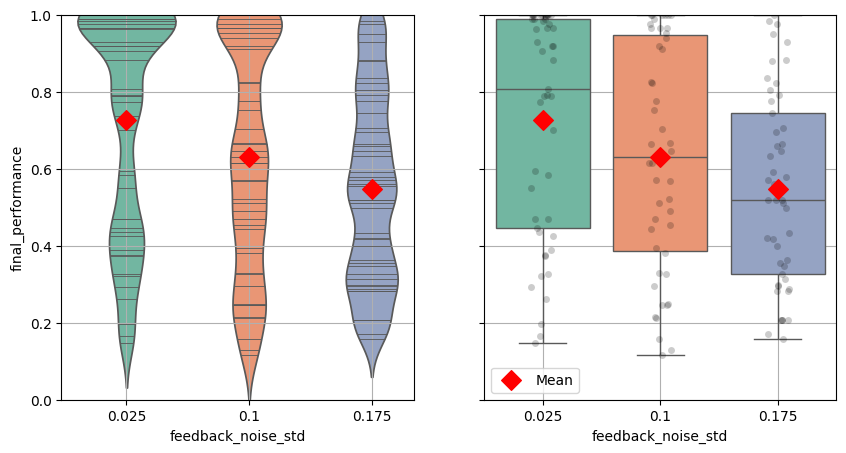

In [13]:
# Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
last_k_trials,last_t_timesteps = 3,5
all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


# And for the blind trial :
blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()





means = subjects_df.groupby('feedback_noise_std')['final_performance'].mean()
# print(subjects_df["performance"])


fig,axs = plt.subplots(1,2,sharey=True,figsize = (10,5))
ax = sns.violinplot(ax=axs[0],x="feedback_noise_std", y="final_performance",
                    data=subjects_df, palette="Set2",
                    scale="area", inner="stick",
                    scale_hue=True, bw=.2)
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')

ax = sns.boxplot(ax=axs[1],x="feedback_noise_std", y="final_performance",
                    data=subjects_df, palette="Set2")

# Adjust zorder and label
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')
# Adding a legend to label the means
ax.legend()

# add stripplot to boxplot with Seaborn
sns.stripplot(ax = axs[1], y='final_performance', x='feedback_noise_std', 
                   data=subjects_df, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

for ax in axs :
    ax.grid()
    ax.set_ylim([0,1])

# # What window of feedback(i.e. distance) values allows us to characterize the perofrmance of subject ?

# feedback_all_subjs_window = feedback_for_all_subjects[:,-last_k_trials-1:-1,-last_t_timesteps:]
#     # The very last trial was without a gauge, it does not count :p
# mean_feedback_all_subjs_last_k_trials = np.mean(feedback_all_subjs_window,axis=(-1,-2))
# performance_metric = mean_feedback_all_subjs_last_k_trials

# # Create a pandas dataframe from the list of subject dictionnaries :
# subjects_df["performance"] = performance_metric.tolist()

C:\Users\annic\AppData\Local\Temp\ipykernel_32392\3368724794.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


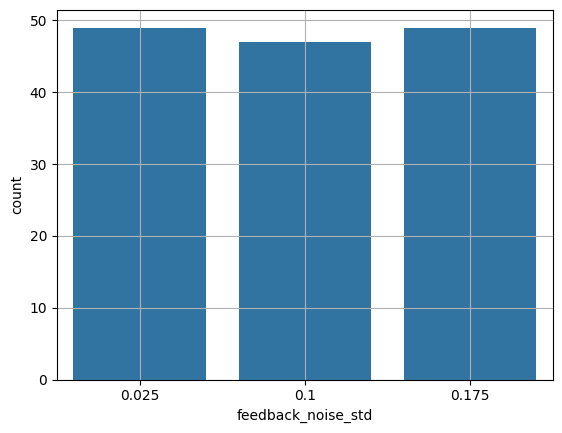

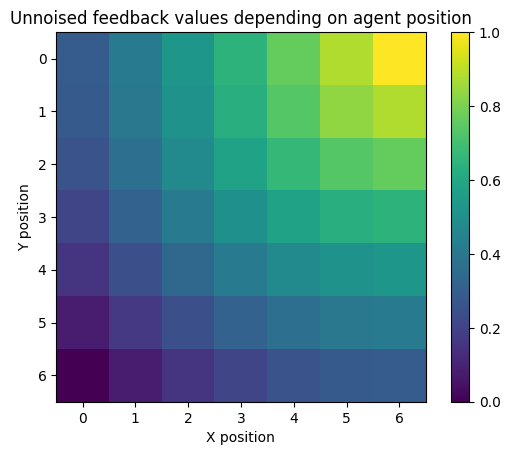

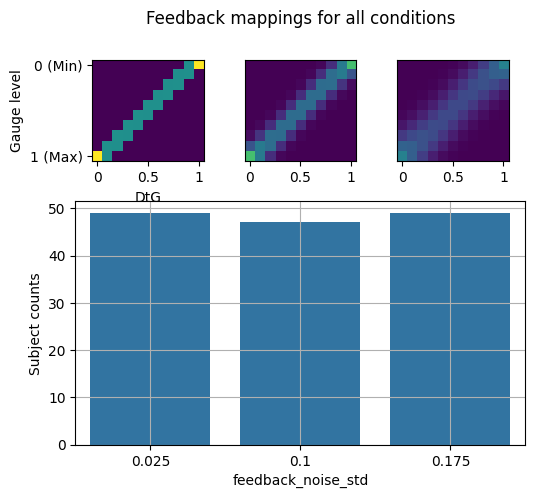

In [14]:
ax = sns.countplot(subjects_df,x="feedback_noise_std")
ax.grid()

from simulate.models_utils import sub2ind,ind2sub,distance,discretized_distribution_from_value,discretize_normal_pdf
from functools import partial
n_feedback_ticks = 10

# Show the equivalent feedback matrices :
grid_size = (7,7)
end_idx = jnp.array([0,6])
flattened_grid = jnp.zeros(grid_size).flatten()
Ns = flattened_grid.shape[0]

maximum_euclidian_dist = euclidian_distance(jnp.array(grid_size) - jnp.ones((2,)),jnp.zeros((2,)))

all_scalar_fb_values = np.zeros((Ns,))
for idx,state in enumerate(flattened_grid):
    cellx,celly = ind2sub(grid_size,idx)
    distance_to_goal = euclidian_distance(jnp.array([cellx,celly]),end_idx)/maximum_euclidian_dist
    all_scalar_fb_values[idx] = 1.0 - distance_to_goal
fig,ax = plt.subplots()
im = ax.imshow(np.reshape(all_scalar_fb_values,grid_size))
fig.colorbar(im)
ax.set_title("Noiseless feedback values depending on agent position")
ax.set_xlabel("X position")
ax.set_ylabel("Y position")



def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")
    
fig = plt.figure(layout=None,figsize=(5,5))
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.95,
                      hspace=0.4, wspace=0.05)
ax0 = fig.add_subplot(gs[1:, :])
# annotate_axes(ax0, 'Subject counts')
sns.countplot(ax = ax0,data=subjects_df,x="feedback_noise_std")
ax0.grid()
ax0.set_ylabel("Subject counts")

# Group by 'key' column
grouped_df = subjects_df.groupby('feedback_noise_std')              

group_values = {}
# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
for i,(key, group) in enumerate(grouped_df):
    ax = fig.add_subplot(gs[0, i])
    # annotate_axes(ax, 'std={}'.format(key))
    
    # Sort distances :
    Npoints = 11
    linear_dist_to_goal = jnp.linspace(0,1,Npoints)
    discretize_distance_normal_function = partial(discretize_normal_pdf,std=key,num_bins = n_feedback_ticks,lower_bound= -1e-5 ,upper_bound = 1.0 + 1e-5)
    a0,edges = vmap(discretize_distance_normal_function,out_axes=-1)(1.0 - linear_dist_to_goal)
    im = ax.imshow(a0,vmin=0.0,vmax=1.0)
    
    if i==0 :
        ax.set_xticks([0,int(Npoints/2),Npoints-1],[0,0.5,1])
        ax.set_yticks([0,n_feedback_ticks-1],["0 (Min)","1 (Max)"])
        # ax.set_title("Noisy feedback values \n depending on agent DtG")
        ax.set_xlabel("DtG")
        ax.set_ylabel("Gauge level")
    else :
        ax.set_xticks([0,int(Npoints/2),Npoints-1],[0,0.5,1])
        ax.set_yticks([])
# fig.colorbar(im)      
fig.suptitle('Feedback mappings for all conditions')
fig.tight_layout()

# # Raw distr :
# discretize_distance_normal_function = partial(discretize_normal_pdf,std=std_show,num_bins = n_feedback_ticks,lower_bound= -1e-5 ,upper_bound = 1.0 + 1e-5)
# a0,edges = vmap(discretize_distance_normal_function,out_axes=-1)(all_scalar_fb_values)
# fig,ax = plt.subplots()
# ax.imshow(a0)


# discretize_distance_normal_function = partial(discretize_normal_pdf,std=std_show,num_bins = 5*n_feedback_ticks,lower_bound= -1e-5 ,upper_bound = 1.0 + 1e-5)
# a0,edges = vmap(discretize_distance_normal_function,out_axes=-1)(all_scalar_fb_values)
# fig,ax = plt.subplots()
# ax.imshow(a0)

## 2. Analyzing the results !

Let's start by the feedback trajectories :

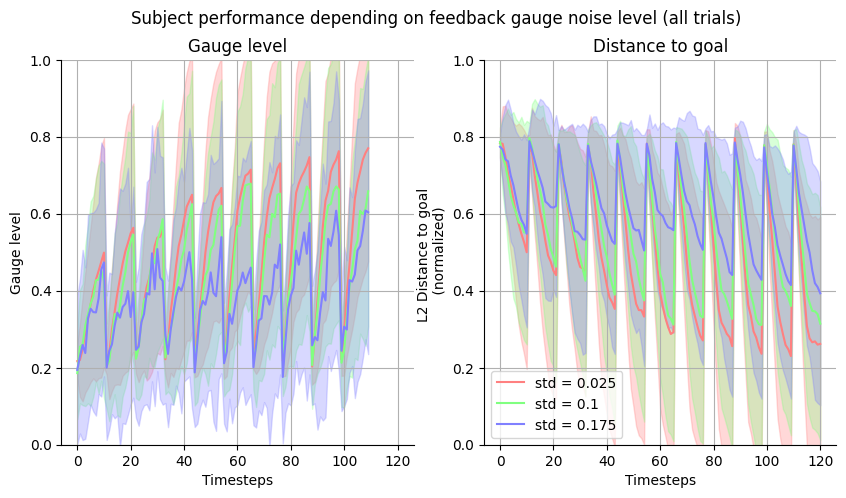

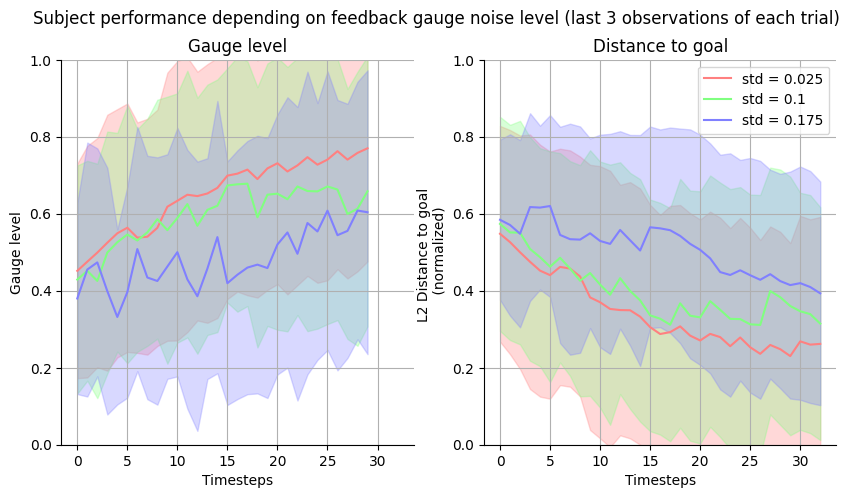

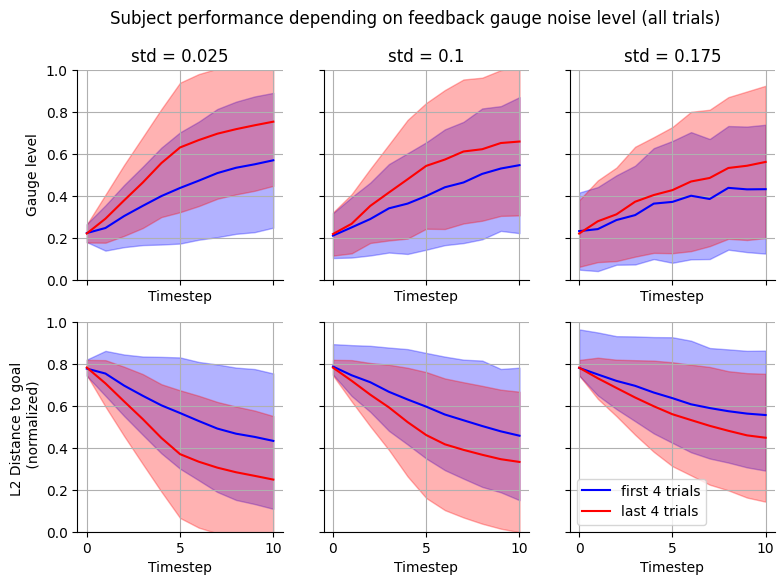

In [15]:
# Group by 'key' column
grouped_df = subjects_df.groupby('feedback_noise_std')              

group_values = {}
# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
for key, group in grouped_df:
    # Stack arrays in the group and compute mean along the first axis
    all_feedbacks =  np.stack(group['raw_feedback_values'])[:,:-1,:]  
                    # We remove the last one as it was not show to the subject !    
    
    all_distances = np.stack(group['norm_distance_to_goal'])[:,:,:]
    # mean_array = np.mean(, axis=-1)
    group_values[key] = {"fb" : {"mean" : np.mean(all_feedbacks,axis=0),"std" : np.std(all_feedbacks,axis=0)},
                         "dist" : {"mean" : np.mean(all_distances,axis=0),"std" : np.std(all_distances,axis=0)}}





fig,axs = plt.subplots(1,2,figsize =(10,5),sharex=True)
fig.suptitle("Subject performance depending on feedback gauge noise level (all trials)")
for ax in axs : 
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Timesteps")
    ax.grid()
    ax.set_ylim([0.0,1.0])
axs[0].set_ylabel("Gauge level")
axs[0].set_title("Gauge level")
axs[1].set_title("Distance to goal")
axs[1].set_ylabel("L2 Distance to goal \n (normalized)")

colors = [np.array([1.0,0.5,0.5]),np.array([0.5,1.0,0.5]),np.array([0.5,0.5,1.0])]
for i,((key, mean_array),col) in enumerate(zip(group_values.items(),colors)):
    mean_arr_fb = mean_array["fb"]["mean"].flatten()
    std_arr_fb =  mean_array["fb"]["std"].flatten()
    timesteps_fb = np.arange(mean_arr_fb.shape[0])
    
    mean_arr_dist = mean_array["dist"]["mean"].flatten()
    std_arr_dist =  mean_array["dist"]["std"].flatten()
    timesteps_dist = np.arange(mean_arr_dist.shape[0])
        
    axs[0].plot(timesteps_fb,mean_arr_fb,color=col,alpha=1,label=f'std = {key}')
    axs[0].fill_between(timesteps_fb,mean_arr_fb - std_arr_fb, mean_arr_fb + std_arr_fb,color=col, alpha = 0.3)
    
    axs[1].plot(timesteps_dist,mean_arr_dist,color=col,alpha=1,label=f'std = {key}')
    axs[1].fill_between(timesteps_dist,mean_arr_dist - std_arr_dist, mean_arr_dist + std_arr_dist,color=col, alpha = 0.3)
ax.legend()

# Only the last K observations :
K = 3
fig,axs = plt.subplots(1,2,figsize =(10,5),sharex=True)
fig.suptitle("Subject performance depending on feedback gauge noise level (last {} observations of each trial)".format(K))
for ax in axs : 
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Timesteps")
    ax.grid()
    ax.set_ylim([0.0,1.0])
axs[0].set_ylabel("Gauge level")
axs[0].set_title("Gauge level")
axs[1].set_title("Distance to goal")
axs[1].set_ylabel("L2 Distance to goal \n (normalized)")


colors = [np.array([1.0,0.5,0.5]),np.array([0.5,1.0,0.5]),np.array([0.5,0.5,1.0])]
for i,((key, mean_array),col) in enumerate(zip(group_values.items(),colors)):
    mean_arr_fb = mean_array["fb"]["mean"][...,-K:].flatten()
    std_arr_fb =  mean_array["fb"]["std"][...,-K:].flatten()
    timesteps_fb = np.arange(mean_arr_fb.shape[0])
    
    mean_arr_dist = mean_array["dist"]["mean"][...,-K:].flatten()
    std_arr_dist =  mean_array["dist"]["std"][...,-K:].flatten()
    timesteps_dist = np.arange(mean_arr_dist.shape[0])
        
    axs[0].plot(timesteps_fb,mean_arr_fb,color=col,alpha=1,label=f'std = {key}')
    axs[0].fill_between(timesteps_fb,mean_arr_fb - std_arr_fb, mean_arr_fb + std_arr_fb,color=col, alpha = 0.3)
    
    axs[1].plot(timesteps_dist,mean_arr_dist,color=col,alpha=1,label=f'std = {key}')
    axs[1].fill_between(timesteps_dist,mean_arr_dist - std_arr_dist, mean_arr_dist + std_arr_dist,color=col, alpha = 0.3)
ax.legend()





# Compare initial and final observations :
K = 4
fig,axs = plt.subplots(2,len(group_values),figsize =(3*len(group_values),3*2),sharex=True,sharey=True)
fig.suptitle("Subject performance depending on feedback gauge noise level (all trials)")
for ax in axs.flatten() : 
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Timestep")
    ax.grid()
    ax.set_ylim([0.0,1.0])
axs[0,0].set_ylabel("Gauge level")
axs[1,0].set_ylabel("L2 Distance to goal \n (normalized)")

for i,((key, mean_array),col) in enumerate(zip(group_values.items(),colors)):
    axs[0,i].set_title(f'std = {key}')
    
    # avg subject mean and std values for the first K and the last K trials 
    # (excluding the last trial with no feedback)
    mean_arr_fb_0 = np.mean(mean_array["fb"]["mean"][:K,...],axis=0)
    std_arr_fb_0 =  np.mean(mean_array["fb"]["std"][:K,...],axis=0)
    mean_arr_fb_1 = np.mean(mean_array["fb"]["mean"][-K:,...],axis=0)
    std_arr_fb_1 =  np.mean(mean_array["fb"]["std"][-K:,...],axis=0)
    timesteps_fb = np.arange(mean_arr_fb_0.shape[0])
    
    mean_arr_dist_0 = np.mean(mean_array["dist"]["mean"][:K,...],axis=0)
    std_arr_dist_0 =  np.mean(mean_array["dist"]["std"][:K,...],axis=0)
    mean_arr_dist_1 = np.mean(mean_array["dist"]["mean"][-K-1:-1,...],axis=0)
    std_arr_dist_1 =  np.mean(mean_array["dist"]["std"][-K-1:-1,...],axis=0)
    timesteps_dist = np.arange(mean_arr_dist_0.shape[0])
        
    axs[0,i].plot(timesteps_fb,mean_arr_fb_0,color="blue",alpha=1,label=f'first {K} trials')
    axs[0,i].fill_between(timesteps_fb,mean_arr_fb_0 - std_arr_fb_0, mean_arr_fb_0 + std_arr_fb_0,color="blue", alpha = 0.3)
    
    axs[0,i].plot(timesteps_fb,mean_arr_fb_1,color="red",alpha=1,label=f'last {K} trials')
    axs[0,i].fill_between(timesteps_fb,mean_arr_fb_1 - std_arr_fb_1, mean_arr_fb_1 + std_arr_fb_1,color="red", alpha = 0.3)
    
    
    axs[1,i].plot(timesteps_dist,mean_arr_dist_0,color="blue",alpha=1,label=f'first {K} trials')
    axs[1,i].fill_between(timesteps_dist,mean_arr_dist_0 - std_arr_dist_0, mean_arr_dist_0 + std_arr_fb_0,color="blue", alpha = 0.3)
    
    axs[1,i].plot(timesteps_dist,mean_arr_dist_1,color="red",alpha=1,label=f'last {K} trials')
    axs[1,i].fill_between(timesteps_dist,mean_arr_dist_1 - std_arr_dist_1, mean_arr_dist_1 + std_arr_dist_1,color="red", alpha = 0.3)
    
ax.legend()


Even when differentiating between feedback conditions, subject performances display a high inter variability. This is due to the nature of the task, which is significantly underconstrained (by design) and forces subjects to develop strategies without any supervision. As the results from the low noise feedback show, even a good indicator still leads to very different training curves within the group.

This validates the results from a previous study that showed that the noise of the feedback was not the only predictor for subject performances. 

Let's now explore a with a bit more detail the shape of the (end of trial) performance graph as it evolves across the training :

(49, 110)
(47, 110)
(49, 110)


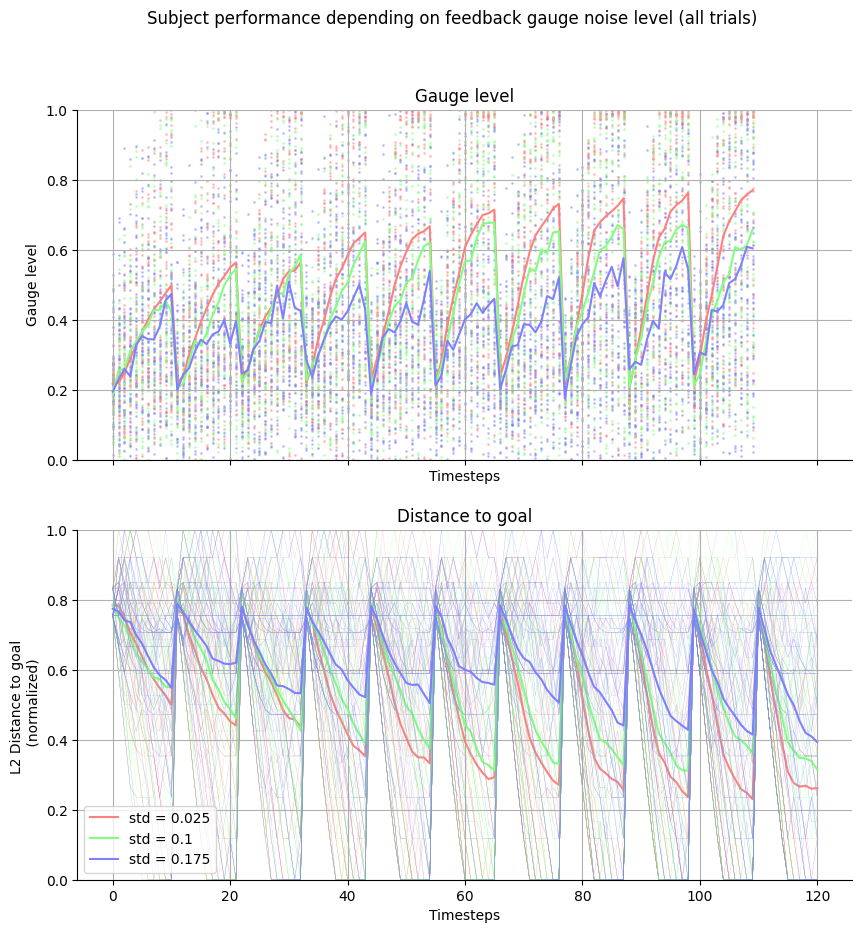

In [16]:
# Group by 'feedback_noise_std' column
grouped_df = subjects_df.groupby('feedback_noise_std')              

group_values = {}
# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
for key, group in grouped_df:
    # Stack arrays in the group and compute mean along the first axis
    all_feedbacks =  np.stack(group['raw_feedback_values'])[:,:-1,:]  
                    # We remove the last one as it was not show to the subject !    
    
    all_distances = np.stack(group['norm_distance_to_goal'])[:,:,:]
    # mean_array = np.mean(, axis=-1)
    
    # Let's stop averaging across subjects, as we've shown there is a huge inter subject variability in our task
    # Let's plot the same graphs as before as point clouds !
    group_values[key] = {"fb" :all_feedbacks, "dist" : all_distances}



fig,axs = plt.subplots(2,1,figsize =(10,10),sharex=True)
fig.suptitle("Subject performance depending on feedback gauge noise level (all trials)")
for ax in axs : 
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Timesteps")
    ax.grid()
    ax.set_ylim([0.0,1.0])
axs[0].set_ylabel("Gauge level")
axs[0].set_title("Gauge level")
axs[1].set_title("Distance to goal")
axs[1].set_ylabel("L2 Distance to goal \n (normalized)")

colors = [np.array([1.0,0.5,0.5]),np.array([0.5,1.0,0.5]),np.array([0.5,0.5,1.0])]
for i,((key, values),col) in enumerate(zip(group_values.items(),colors)):
    arr_fb = np.reshape(values["fb"],(values["fb"].shape[0],-1))
    print(arr_fb.shape)
    mean_arr_fb =  np.mean(values["fb"],axis=0).flatten()
    timesteps_fb = np.arange(arr_fb.shape[1])
    
    arr_dist = np.reshape(values["dist"],(values["dist"].shape[0],-1))
    mean_arr_dist =  np.mean(values["dist"],axis=0).flatten()
    timesteps_dist = np.arange(arr_dist.shape[1])
        
    axs[0].plot(timesteps_fb,mean_arr_fb,color=col,alpha=1,label=f'std = {key}')
    for s in range(arr_fb.shape[0]):
        axs[0].scatter(timesteps_fb,arr_fb[s],color=col,alpha=0.4,s=1)
    
    
    axs[1].plot(timesteps_dist,mean_arr_dist,color=col,alpha=1,label=f'std = {key}')
    for s in range(arr_fb.shape[0]):
        axs[1].plot(timesteps_dist,arr_dist[s],color=col,alpha=0.4,lw=0.25)
ax.legend()


This remains pretty hard to see, let's show the evolutive distribution of performances as trials go by :

C:\Users\annic\AppData\Local\Temp\ipykernel_32392\2240288688.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


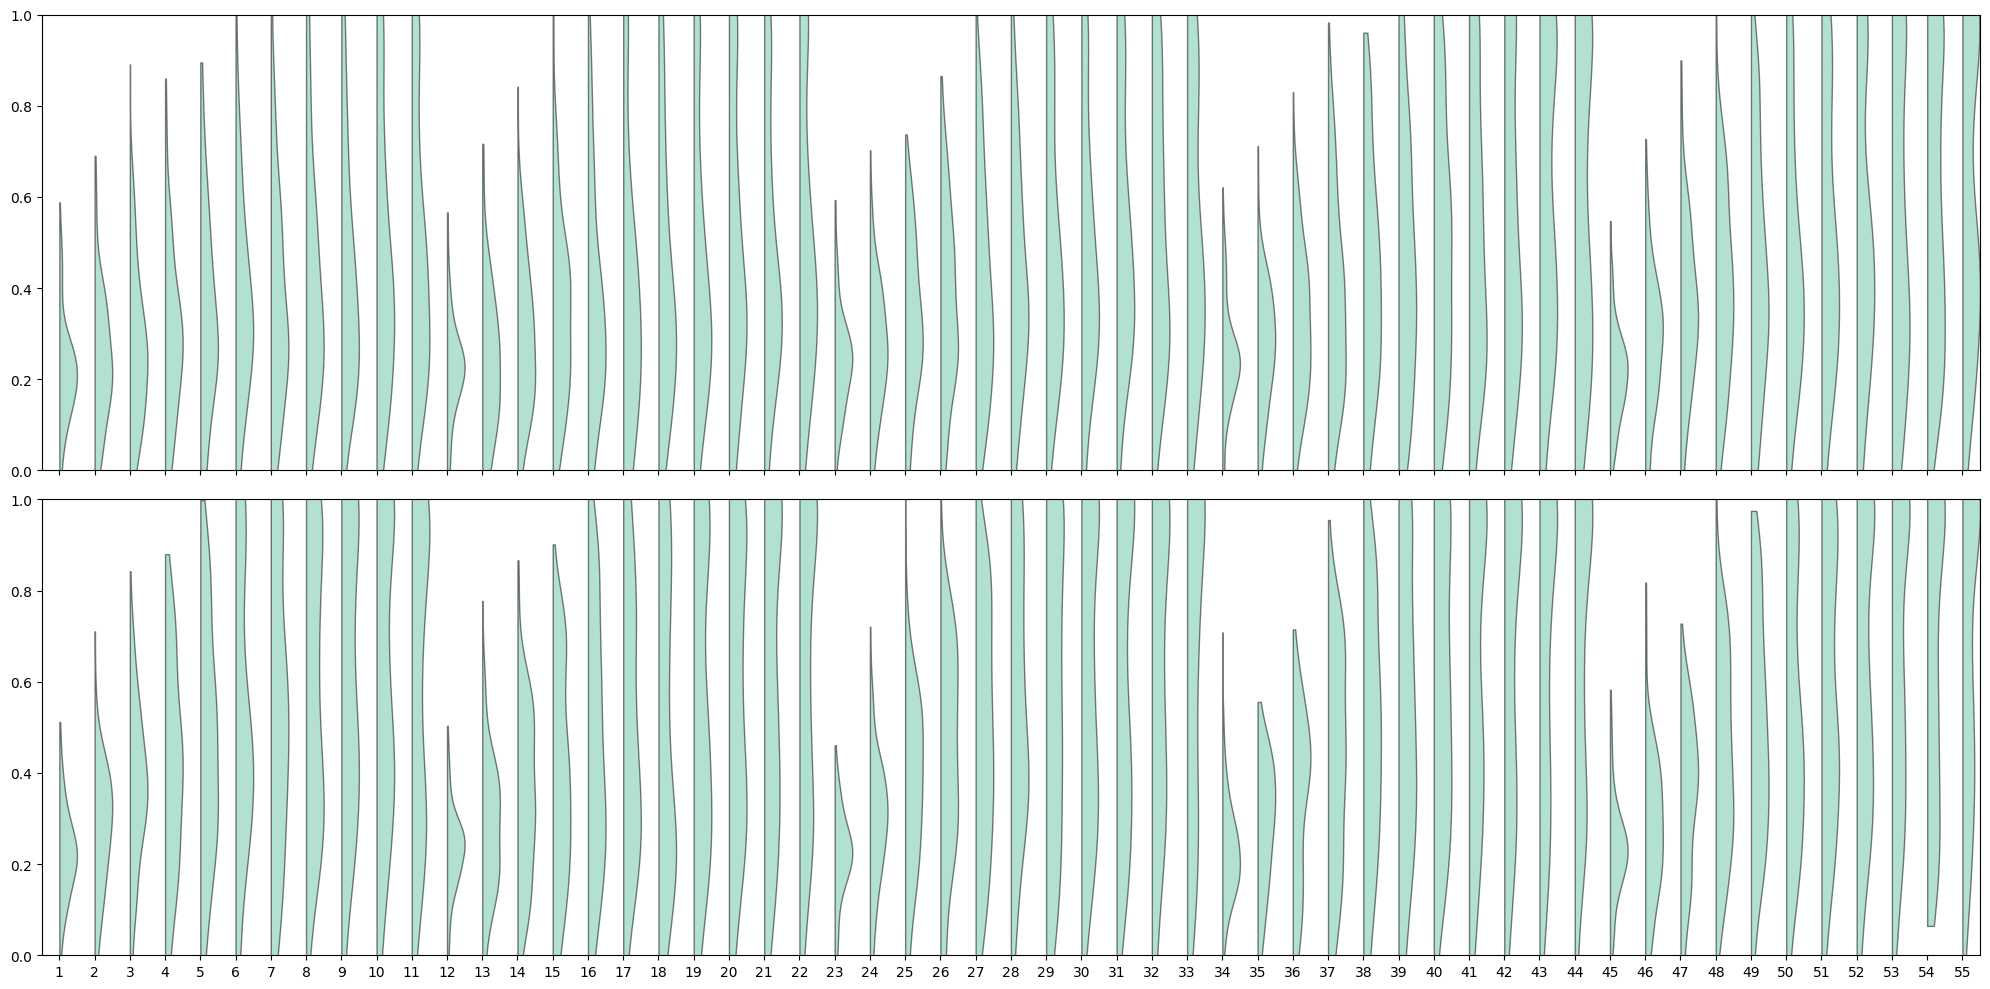

In [17]:
from statsmodels.graphics.boxplots import violinplot

# Group by 'feedback_noise_std' column
grouped_df = subjects_df.groupby('feedback_noise_std')              

group_values = {}
# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_feedbacks =  np.stack(subjects_df['raw_feedback_values'])[:,:-1,:]
all_distances = np.stack(subjects_df['norm_distance_to_goal'])[:,:,:]
all_noise_fb_parameters = subjects_df["feedback_noise_std"]
Nsubjs = all_feedbacks.shape[0]

violoin_plotopts = {
    "cutoff":True,
    "violin_width":1.0
}

K = 5
fig, axs = plt.subplots(2,1,figsize=(20,10),sharex=True)
for ax in axs : 
    ax.set_ylim([0,1])

# Only look at the first K : 
all_feedbacks_first =  np.reshape(all_feedbacks[:,:K,:],(Nsubjs,-1)) # Reshape arrays to look at the whole training in one go
all_distances_first =  np.reshape(all_feedbacks[:,:K,:],(Nsubjs,-1))

# New dataframe : entries are steps in the training, columns are subjects : 
Nsteps = all_feedbacks.shape[-1]
df_fb = pd.DataFrame(all_feedbacks_first.T,columns=["s"]*Nsubjs)
violinplot(data=df_fb.values, ax=axs[0], side='right', show_boxplot=False,plot_opts=violoin_plotopts)

# And the last K : 
all_feedbacks_last =  np.reshape(all_feedbacks[:,-K:,:],(Nsubjs,-1)) # Reshape arrays to look at the whole training in one go
all_distances_last =  np.reshape(all_feedbacks[:,-K-1:-1,:],(Nsubjs,-1))

# New dataframe : entries are steps in the training, columns are subjects : 
df_fb = pd.DataFrame(all_feedbacks_last.T,columns=["s"]*Nsubjs)
violinplot(data=df_fb.values, ax=axs[1], side='right', show_boxplot=False,plot_opts=violoin_plotopts)

fig.tight_layout()
fig.show()

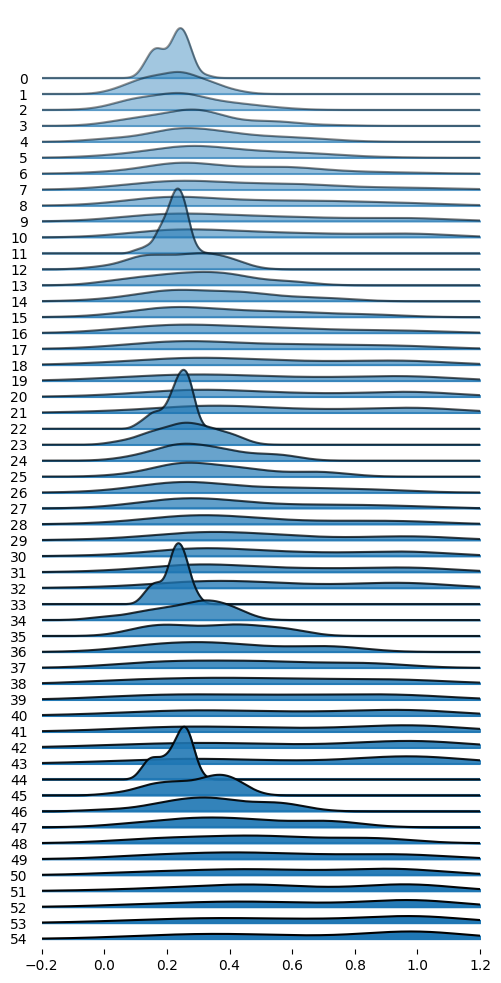

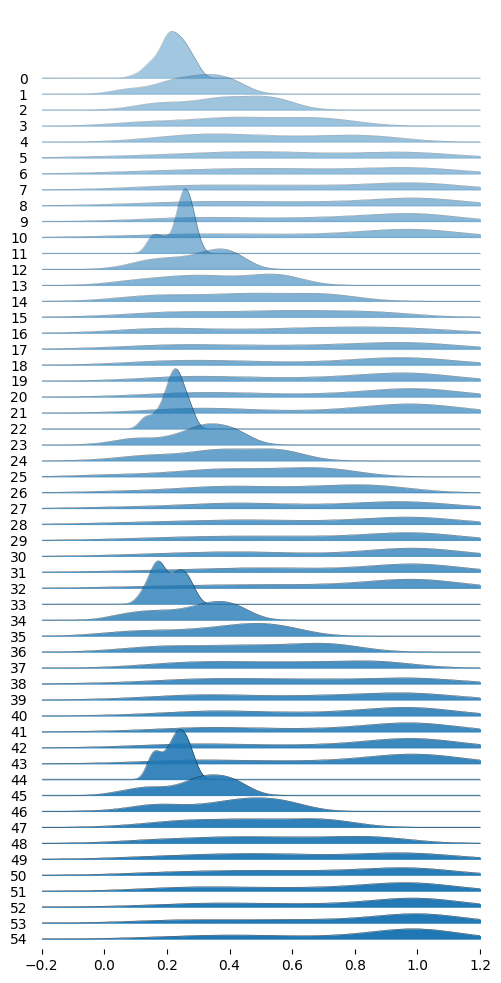

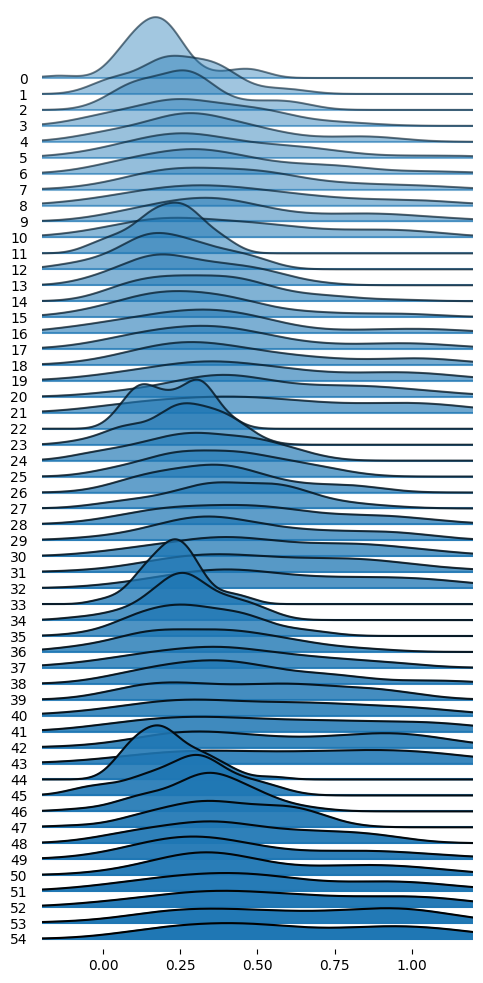

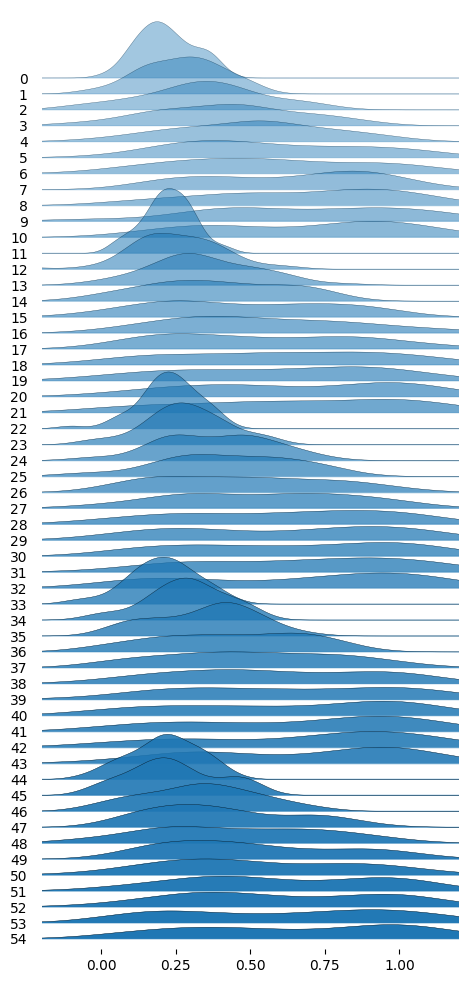

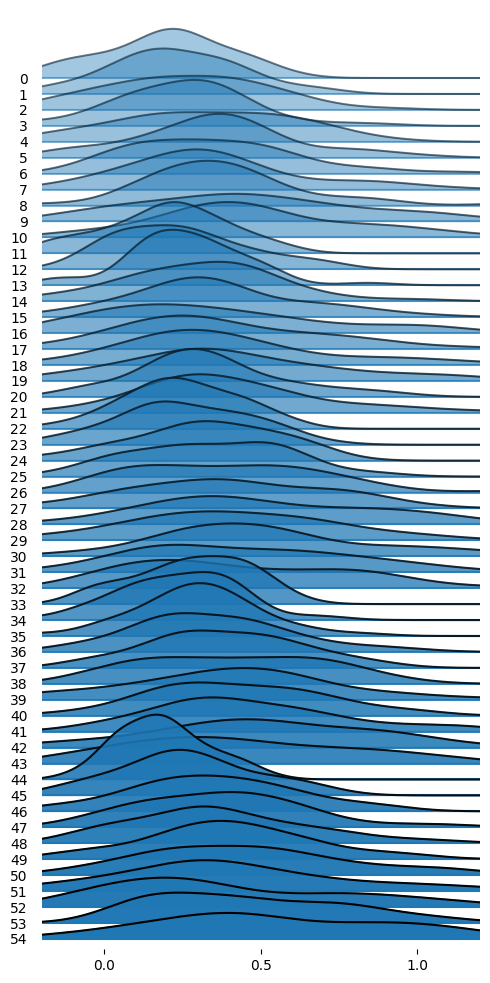

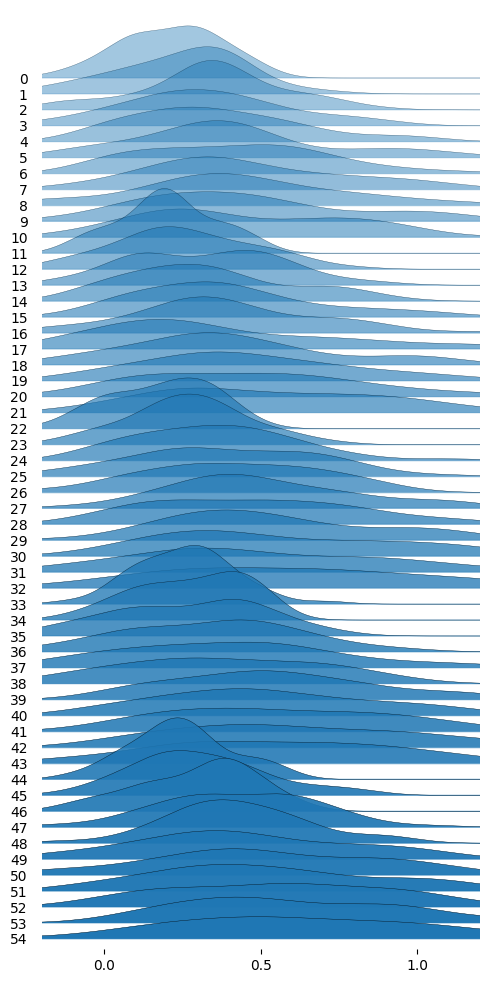

In [18]:
# Alternative plot : 
import joypy

eps = 0.2

# Group by 'feedback_noise_std' column
grouped_df = subjects_df.groupby('feedback_noise_std')              

group_values = {}

for key,group in grouped_df:
    # Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
    all_feedbacks =  np.stack(group['raw_feedback_values'])[:,:-1,:]
    all_distances = np.stack(group['norm_distance_to_goal'])[:,:,:]
    Nsubjs = all_feedbacks.shape[0]

    # Only look at the first K : 
    K = 5
    all_feedbacks_first =  np.reshape(all_feedbacks[:,:K,:],(Nsubjs,-1)) # Reshape arrays to look at the whole training in one go
    all_distances_first =  np.reshape(all_feedbacks[:,:K,:],(Nsubjs,-1))

    # New dataframe : entries are steps in the training, columns are subjects : 
    Nsteps = all_feedbacks_first.shape[-1]
    df_fb = pd.DataFrame(all_feedbacks_first,columns=range(Nsteps))

    fig, axes = joypy.joyplot(df_fb,fade=True,figsize=(5,10))
    for ax in axes:
        ax.set_xlim([0-eps,1+eps])
        
        
    # And the last K : 
    all_feedbacks_last =  np.reshape(all_feedbacks[:,-K:,:],(Nsubjs,-1)) # Reshape arrays to look at the whole training in one go
    all_distances_last =  np.reshape(all_feedbacks[:,-K-1:-1,:],(Nsubjs,-1))

    # New dataframe : entries are steps in the training, columns are subjects : 
    Nsteps = all_feedbacks_first.shape[-1]
    df_fb = pd.DataFrame(all_feedbacks_last,columns=range(Nsteps))

    fig, axes = joypy.joyplot(df_fb,fade=True,figsize=(5,10),linewidth=0.25,)
    for ax in axes:
        ax.set_xlim([0-eps,1+eps])

[[0.1   0.1   0.1   ... 0.1   0.1   0.1  ]
 [0.1   0.1   0.1   ... 0.1   0.1   0.1  ]
 [0.1   0.1   0.1   ... 0.1   0.1   0.1  ]
 ...
 [0.175 0.175 0.175 ... 0.175 0.175 0.175]
 [0.175 0.175 0.175 ... 0.175 0.175 0.175]
 [0.175 0.175 0.175 ... 0.175 0.175 0.175]]
      trial  subject  final_fb  final_distance  noise
0         0        0  0.261292        0.711984  0.100
1         1        0  0.931199        0.000000  0.100
2         2        0  0.858679        0.176777  0.100
3         3        0  1.050024        0.000000  0.100
4         4        0  0.968703        0.000000  0.100
...     ...      ...       ...             ...    ...
1445      5      144  0.385910        0.653058  0.175
1446      6      144  0.449636        0.648181  0.175
1447      7      144  0.197297        0.876890  0.175
1448      8      144  1.076232        0.000000  0.175
1449      9      144  1.077671        0.000000  0.175

[1450 rows x 5 columns]


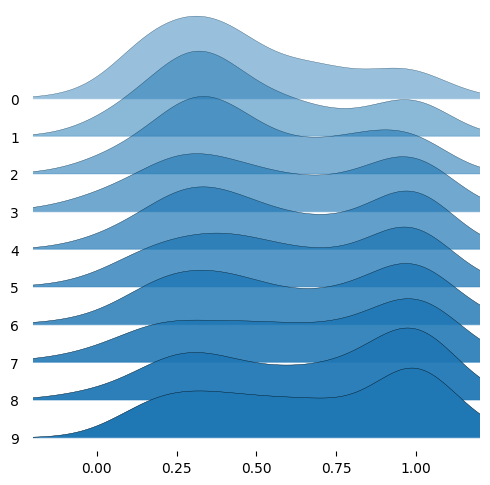

<Figure size 1000x600 with 0 Axes>

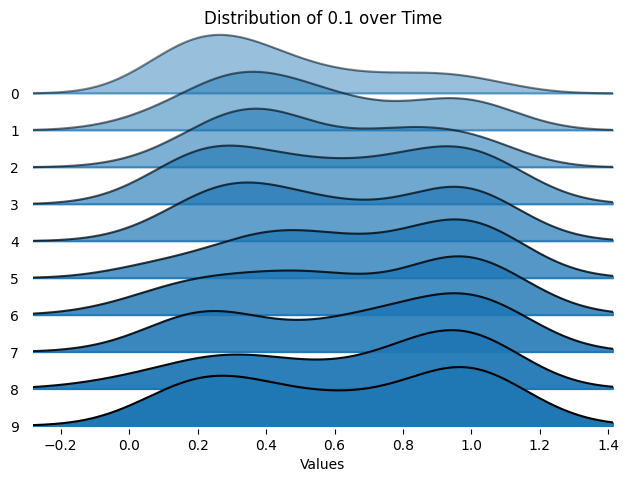

<Figure size 1000x600 with 0 Axes>

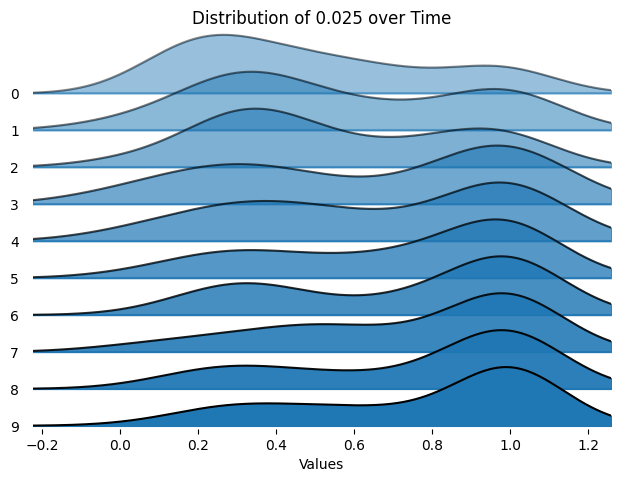

<Figure size 1000x600 with 0 Axes>

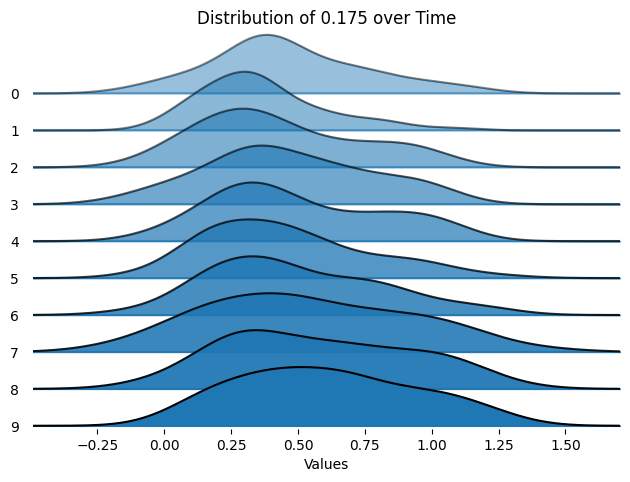

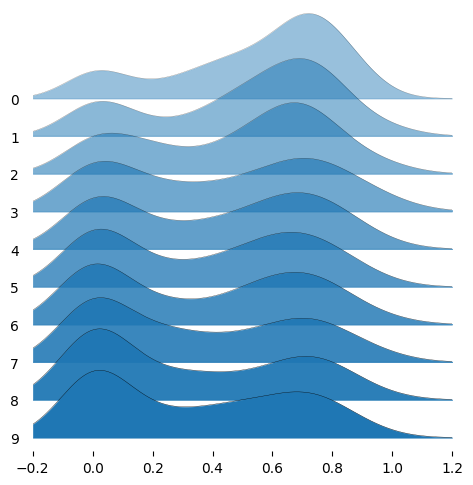

<Figure size 1000x600 with 0 Axes>

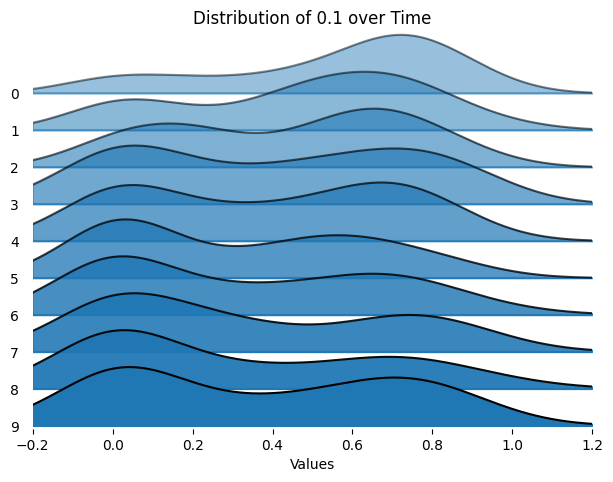

<Figure size 1000x600 with 0 Axes>

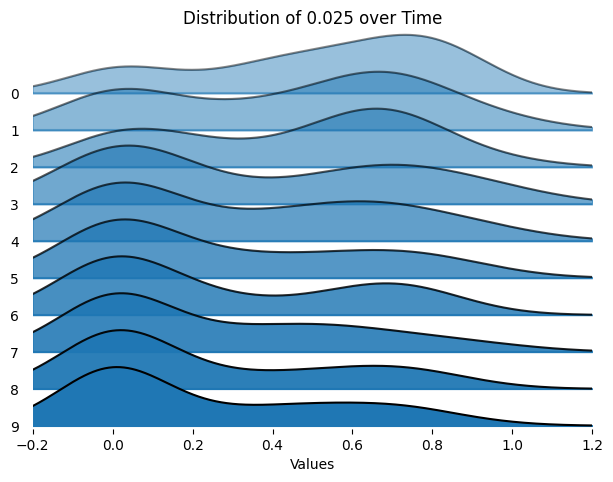

<Figure size 1000x600 with 0 Axes>

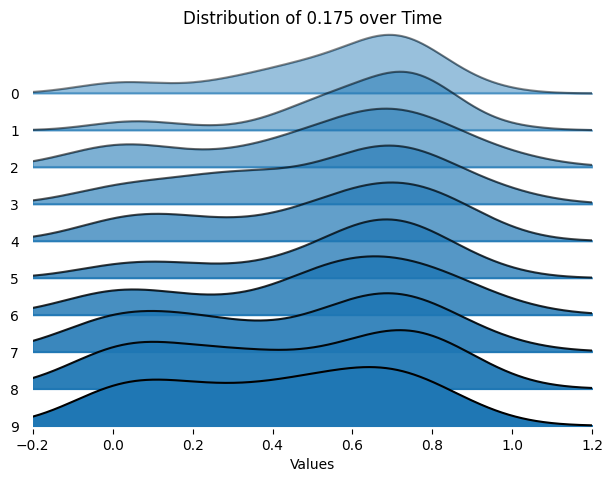

In [19]:
# Final plot : only look at the last tfin timesteps 
import joypy

eps = 0.2
tfin = 2

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_feedbacks = np.stack(subjects_df['raw_feedback_values'])[:,:-1,:]
all_distances = np.stack(subjects_df['norm_distance_to_goal'])[:,:-1,:]
Nsubjs = all_feedbacks.shape[0]

# Only look at the last timesteps avg : 
all_feedbacks = np.mean(all_feedbacks[:,:,-tfin:],axis=-1)
all_distances = np.mean(all_distances[:,:,-tfin:],axis=-1)
Nsteps = all_feedbacks.shape[-1]

all_subject_indexes = np.repeat(np.expand_dims(np.arange(Nsubjs),1),Nsteps,1)
all_trials_indexes = np.repeat(np.expand_dims(np.arange(Nsteps),0),Nsubjs,0)

all_noises = np.repeat(np.expand_dims(np.array(subjects_df['feedback_noise_std']),1),Nsteps,1)
print(all_noises)

# Dataframe : columns : step x subject_id x noise_level x final_feedback x final_distance
new_df = pd.DataFrame()
new_df["trial"] = list(all_trials_indexes.flatten())
new_df["subject"] = list(all_subject_indexes.flatten())
new_df["final_fb"] = list(all_feedbacks.flatten())
new_df["final_distance"] = list(all_distances.flatten())
new_df["noise"] = list(all_noises.flatten())
print(new_df)


# Feedback noise plot :
fig, axes = joypy.joyplot(new_df,by="trial",column="final_fb",
                          fade=True,figsize=(5,5),linewidth=0.25)
for ax in axes:
    ax.set_xlim([0-eps,1+eps])
    
# Separate the data for each class
for cls in new_df['noise'].unique():
    df_class = new_df[new_df['noise'] == cls]
    
    plt.figure(figsize=(10, 6))
    
    joypy.joyplot(
        data=df_class,
        by='trial',
        column='final_fb',
        ylim='own',
        overlap=0.5,
        title=f'Distribution of {cls} over Time',
        fade=True
    )
    
    plt.xlabel('Values')
    plt.show()

# Feedback noise plot :
fig, axes = joypy.joyplot(new_df,by="trial",column="final_distance",
                          fade=True,figsize=(5,5),linewidth=0.25)
for ax in axes:
    ax.set_xlim([0-eps,1+eps])
    
# Separate the data for each class
for cls in new_df['noise'].unique():
    df_class = new_df[new_df['noise'] == cls]
    
    plt.figure(figsize=(10, 6))
    
    joypy.joyplot(
        data=df_class,
        by='trial',
        column='final_distance',
        ylim='own',
        overlap=0.5,
        title=f'Distribution of {cls} over Time',
        fade=True
    )
    
    plt.xlabel('Values')
    plt.show()

## Actions : 

Let's focus on subject actions :

We may consider that each couple of point is the result of a weighted composition of action model hypotheses. To be clearer, each couple of point can be seen as the realization of one (or several) specific beliefs about how the feedback is controlled. One possible composition of hypotheses is :
- (H1) - The feedback may answer to where (on the grey screen) is the baricenter of the points I dropped
- (H2) - The feedback may answer to how far from one another the points are
- (H3) - The feedback may answer to where the second point is relative to the first
- (H4) - The feedback may answer to temporal elements, such as how quickly the action is performed or based on the dynamics of the gauge

Let's transform the point coordinates to fit each of those hypotheses : 

### H1 : position of the barycenter :

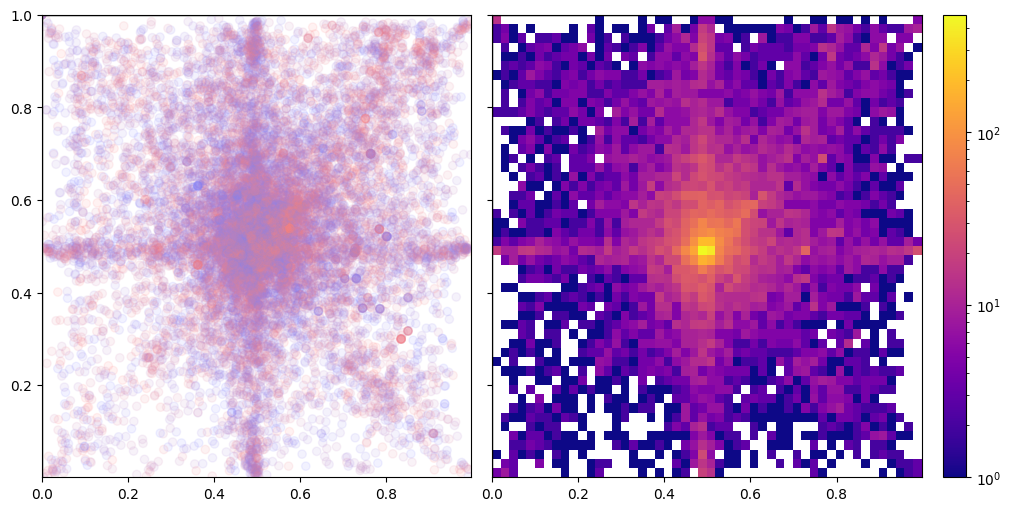

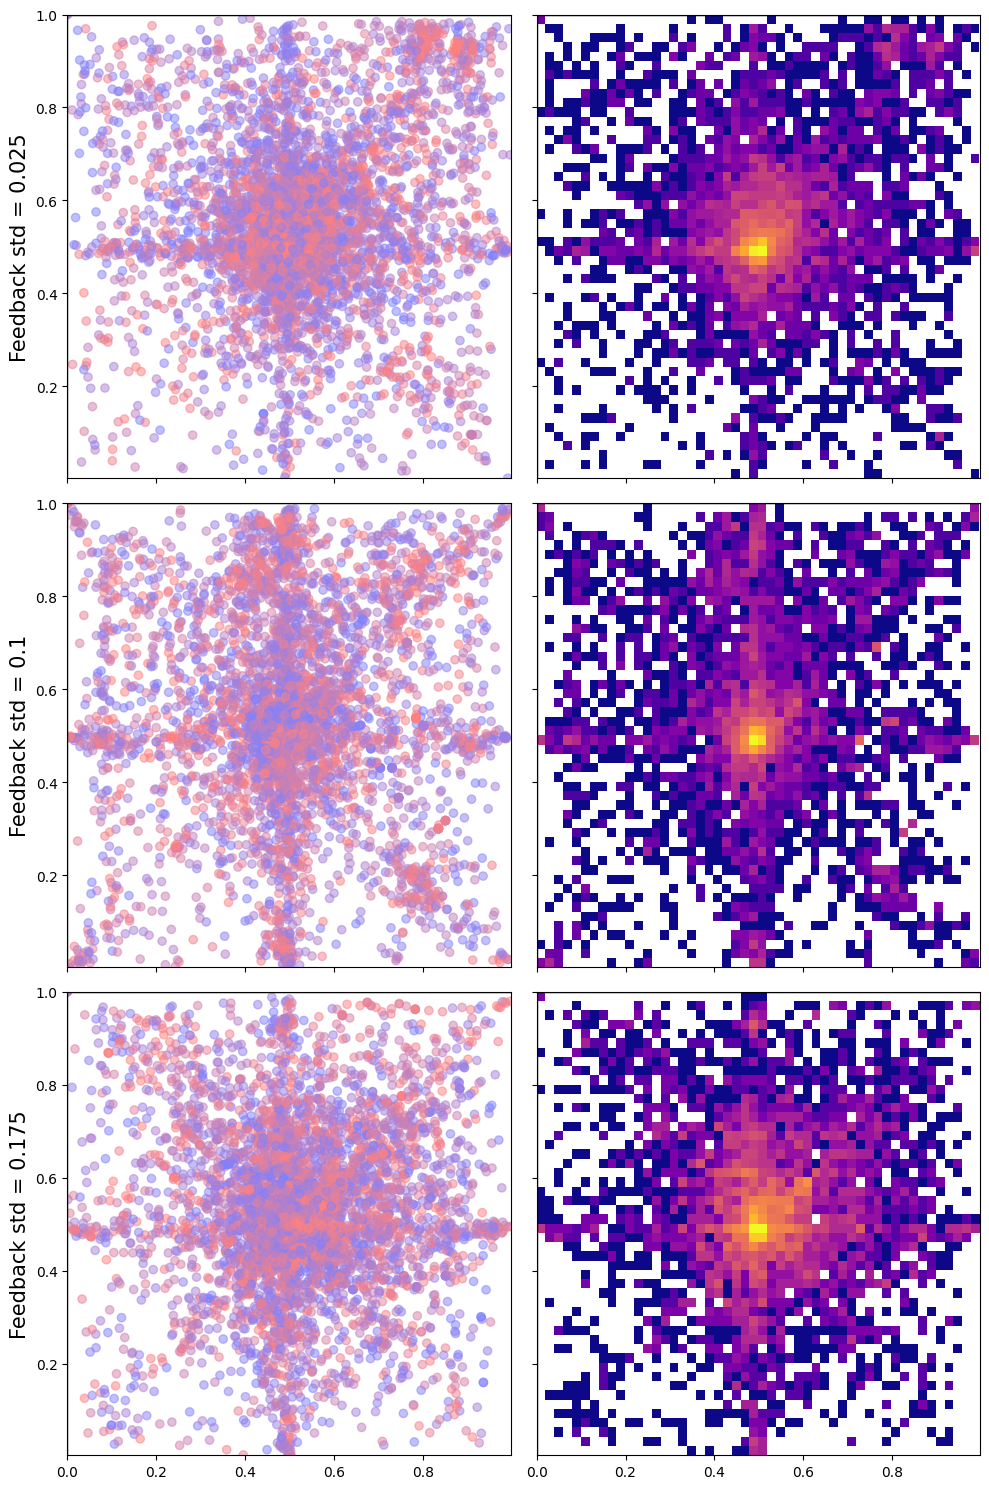

In [27]:
# Noise independent : 
barycenters_all = np.stack(subjects_df["action_barycenters"])
# # Color the barycenter depending on the "age" of the point : 
COLD_COLOR = np.array([0.5,0.5,1.0])
HOT_COLOR = np.array([1.0,0.5,0.5])

fig,axes = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,constrained_layout=True)
for ax in axes :
    ax.axvline(0.0,lw=1.0,color="black")
    ax.axvline(1.0,lw=1.0,color="black")
    ax.axhline(0.0,lw=1.0,color="black")
    ax.axhline(1.0,lw=1.0,color="black")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
ax = axes[0]
Nsubj = barycenters_all.shape[0]
color_array = np.reshape(np.repeat(np.expand_dims(np.linspace(COLD_COLOR,HOT_COLOR,barycenters_all.shape[1]),1),10,1),(-1,3))
for subj in range(Nsubj):
    bary_s = np.reshape(barycenters_all[subj,...],(-1,2))
    ax.scatter(bary_s[...,0],bary_s[...,1],alpha=0.1,color=color_array)

ax = axes[1]
bary_s = np.reshape(barycenters_all,(-1,2))
h = ax.hist2d(bary_s[...,0],bary_s[...,1],bins=(50,50),norm=mpl.colors.LogNorm(),cmap = "plasma")
# fig.colorbar(im,cax=ax)

# fig.subplots_adjust(right=0.85)
fig.colorbar(h[3], ax=ax)
# fig.tight_layout()


# Group by 'key' column
grouped_df = subjects_df.groupby('feedback_noise_std')              
Ncategories = len(grouped_df)

fig,axes = plt.subplots(Ncategories,2,figsize=(10,5*Ncategories),sharex=True,sharey=True)
for ax in axes.flatten() :
    ax.axvline(0.0,lw=1.0,color="black")
    ax.axvline(1.0,lw=1.0,color="black")
    ax.axhline(0.0,lw=1.0,color="black")
    ax.axhline(1.0,lw=1.0,color="black")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

group_values = {}
for i,(key, group) in enumerate(grouped_df):
    axes_for_param = axes[i]
    
    barycenters_group = np.stack(group["action_barycenters"])

    ax = axes_for_param[0]
    
    ax.set_ylabel("Feedback std = {}".format(key),fontsize=15)
    
    Nsubj = barycenters_group.shape[0]
    color_array = np.reshape(np.repeat(np.expand_dims(np.linspace(COLD_COLOR,HOT_COLOR,barycenters_group.shape[1]),1),10,1),(-1,3))
    for subj in range(Nsubj):
        bary_s = np.reshape(barycenters_group[subj,...],(-1,2))
        ax.scatter(bary_s[...,0],bary_s[...,1],alpha=0.5,color=color_array)

    ax = axes_for_param[1]
    bary_s = np.reshape(barycenters_group,(-1,2))
    ax.hist2d(bary_s[...,0],bary_s[...,1],bins=(50,50),norm=mpl.colors.LogNorm(),cmap = "plasma")
    fig.tight_layout()

## H2 : Distance between points

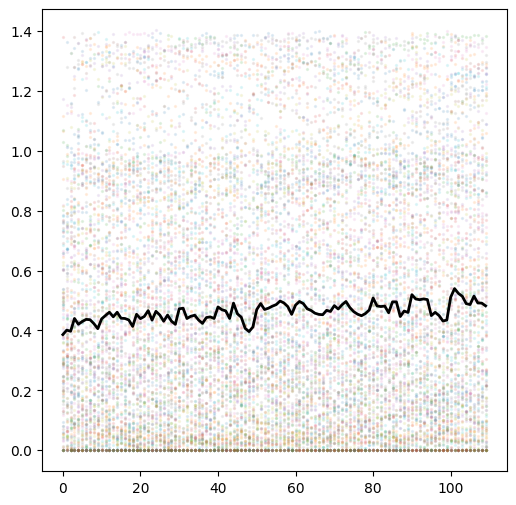

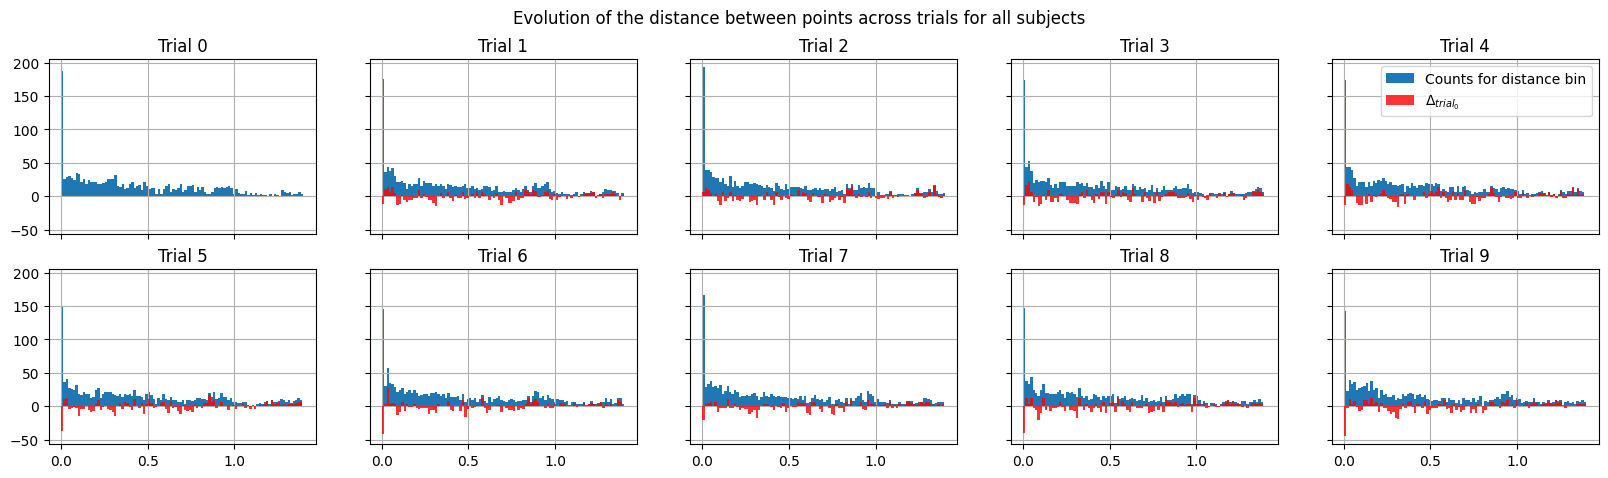

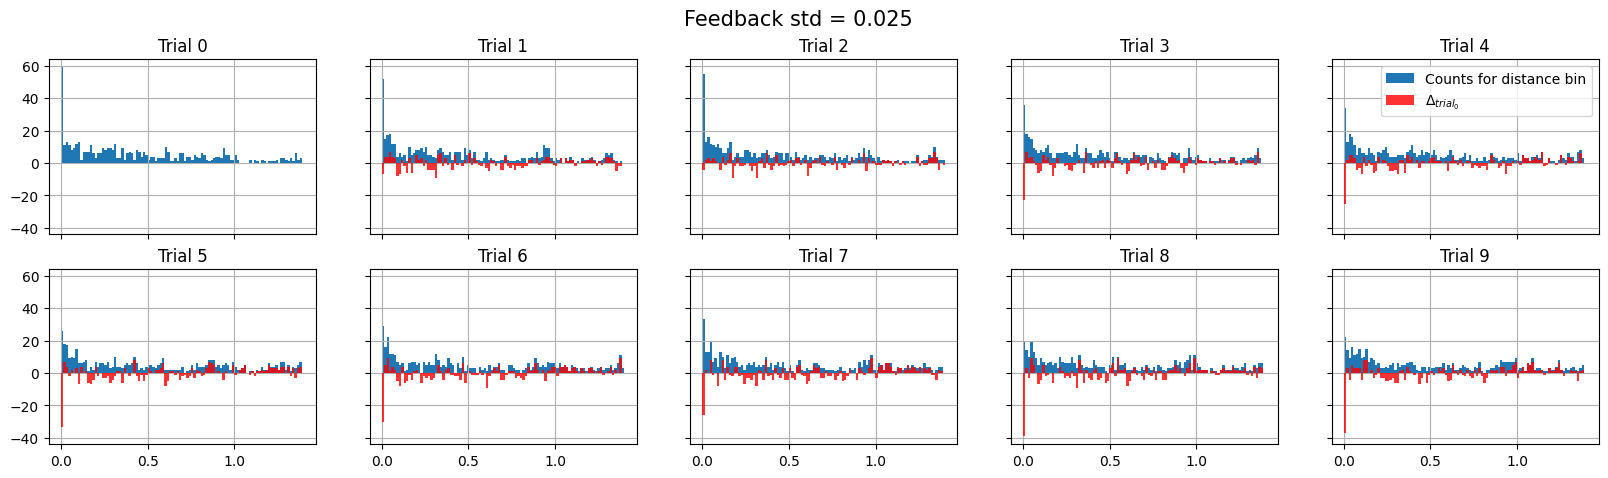

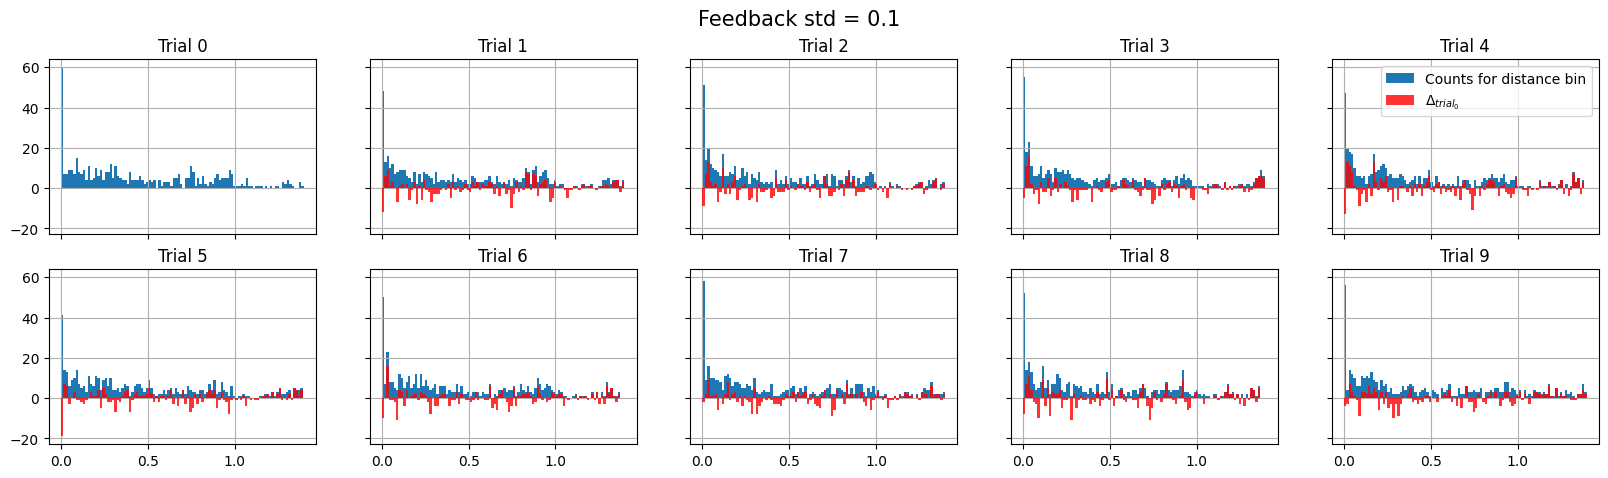

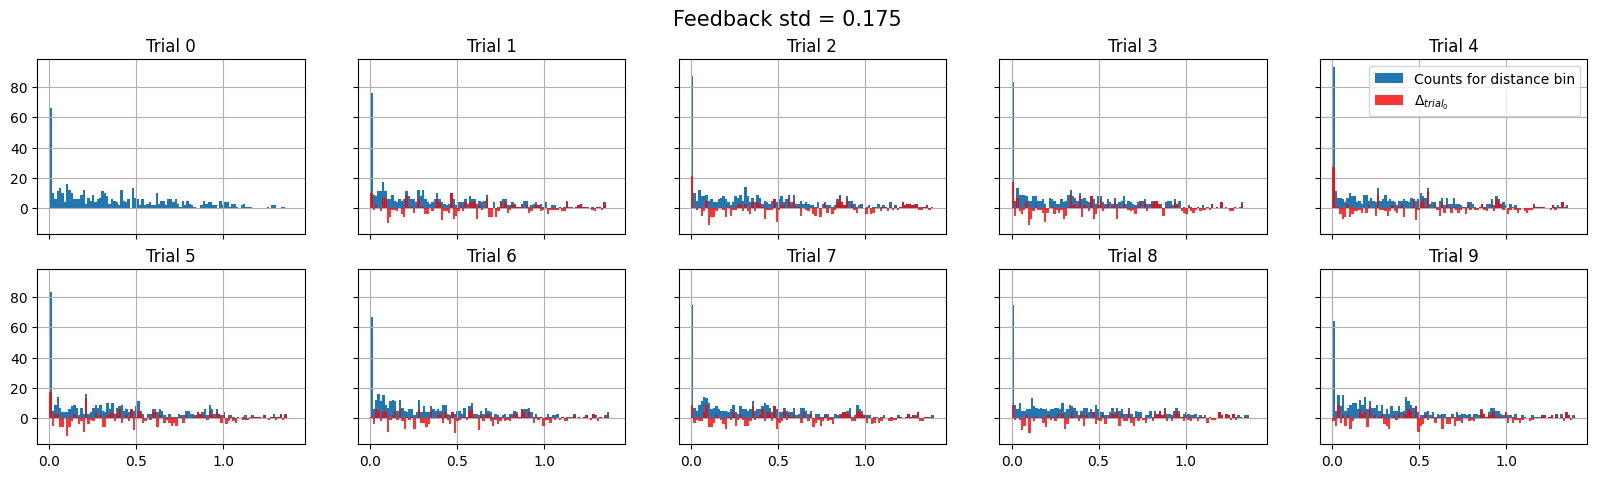

In [28]:
gridx,gridy = 2,5
nbins=100

# Noise independent : 
distances_all = np.stack(subjects_df["action_distances"])
Nsubj = distances_all.shape[0]
flattened_action_distances = np.reshape(action_distances,(Nsubj,-1))


fig,ax = plt.subplots(1,figsize=(6,6))
Nactions = flattened_action_distances.shape[-1]
ax.plot(np.arange(Nactions),np.mean(flattened_action_distances,0),lw=2.0,color="black")
for subj in range(Nsubj):
    ax.scatter(np.arange(Nactions),flattened_action_distances[subj],alpha=0.1,s=2)

fig,axs = plt.subplots(gridx,gridy,figsize=(20,5),sharex=True,sharey=True)
fig.suptitle("Evolution of the distance between points across trials for all subjects")
for trial in range(Ntrials-1):
    ax = axs.flatten()[trial]
    ax.grid()
    ax.set_title("Trial {}".format(trial))
    # ax.hist(angles[:,trial,:].flatten(),bins=16)
    
    counts, edges, bars = ax.hist(action_distances[:,trial,:].flatten(), bins=nbins,histtype='barstacked',label="Counts for distance bin")
        
    if trial==0:
        initial_counts = counts
    else :
        delta_counts = counts-initial_counts
        ax.hist(edges[:-1],edges,weights=delta_counts,color="red",alpha=0.8,zorder=1000,label="$\Delta_{trial_0}$")
axs[0,-1].legend()


# Group by 'key' column
grouped_df = subjects_df.groupby('feedback_noise_std')              
Ncategories = len(grouped_df)

group_values = {}
for i,(key, group) in enumerate(grouped_df):
    action_distances_group = np.stack(group["action_distances"])
    
    fig,axs = plt.subplots(gridx,gridy,figsize=(20,5),sharex=True,sharey=True)
    fig.suptitle("Feedback std = {}".format(key),fontsize=15)
    
    for trial in range(Ntrials-1):
        ax = axs.flatten()[trial]
        ax.grid()
        ax.set_title("Trial {}".format(trial))
        # ax.hist(angles[:,trial,:].flatten(),bins=16)
        
        counts, edges, bars = ax.hist(action_distances_group[:,trial,:].flatten(), bins=nbins,histtype='barstacked',label="Counts for distance bin")
            
        if trial==0:
            initial_counts = counts
        else :
            delta_counts = counts-initial_counts
            ax.hist(edges[:-1],edges,weights=delta_counts,color="red",alpha=0.8,zorder=1000,label="$\Delta_{trial_0}$")
    axs[0,-1].legend()

### H3 : Angle between points

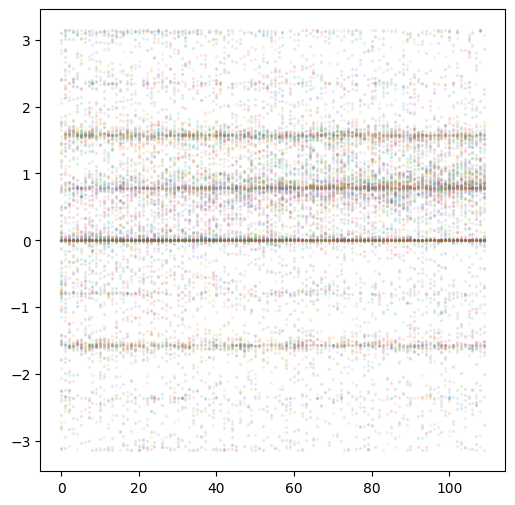

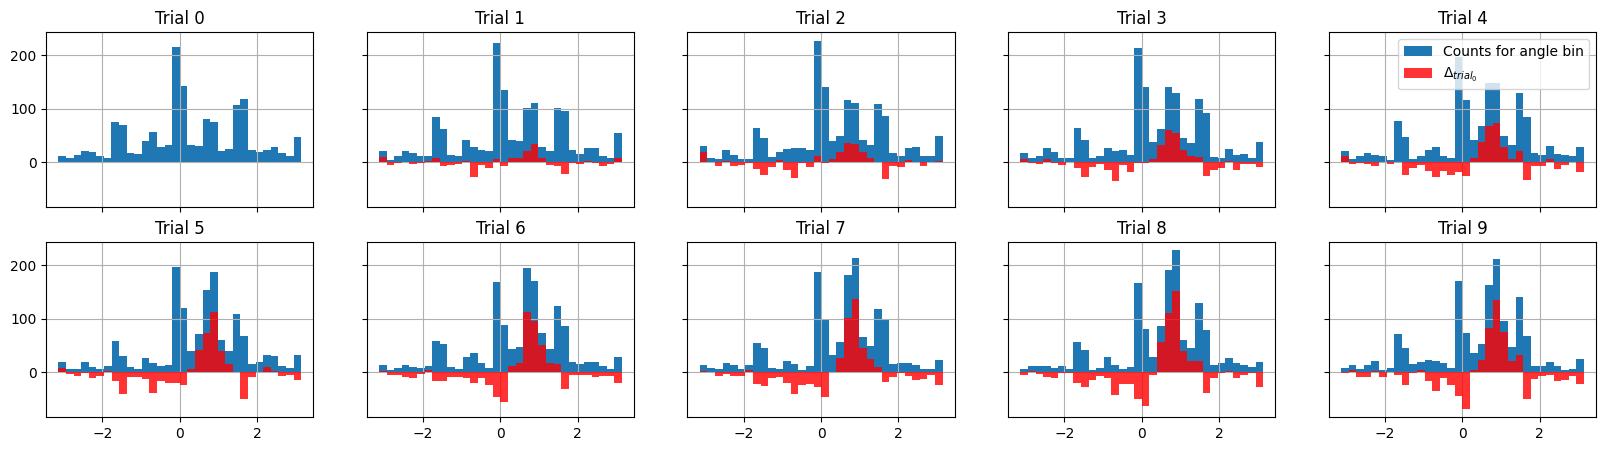

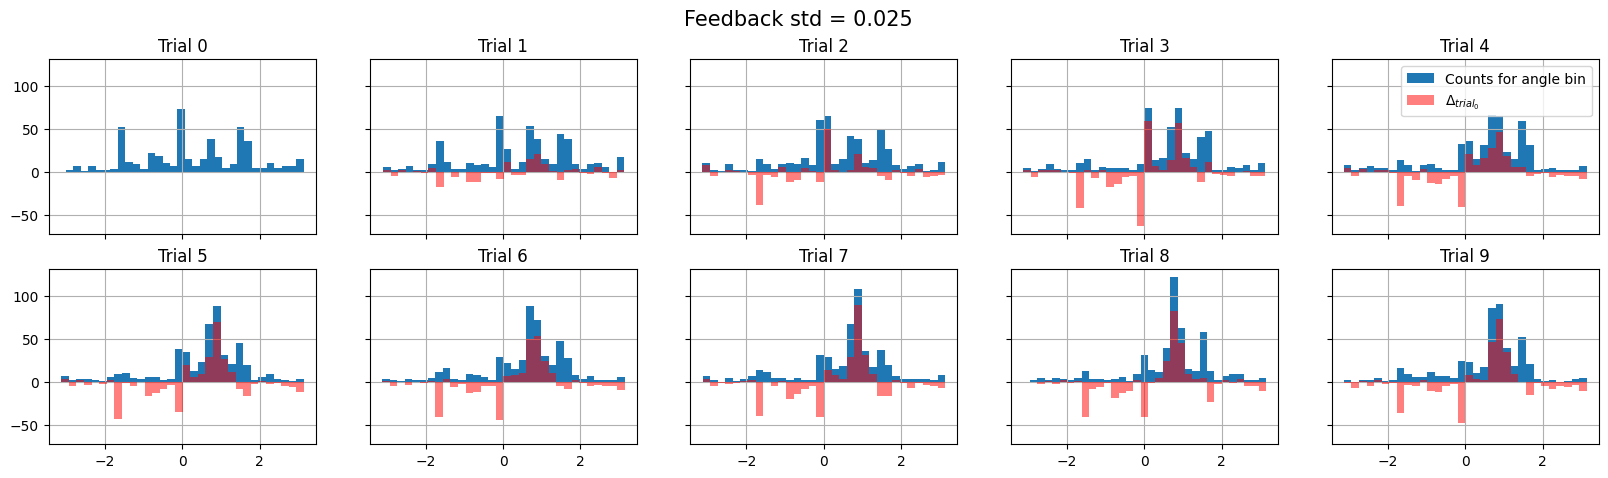

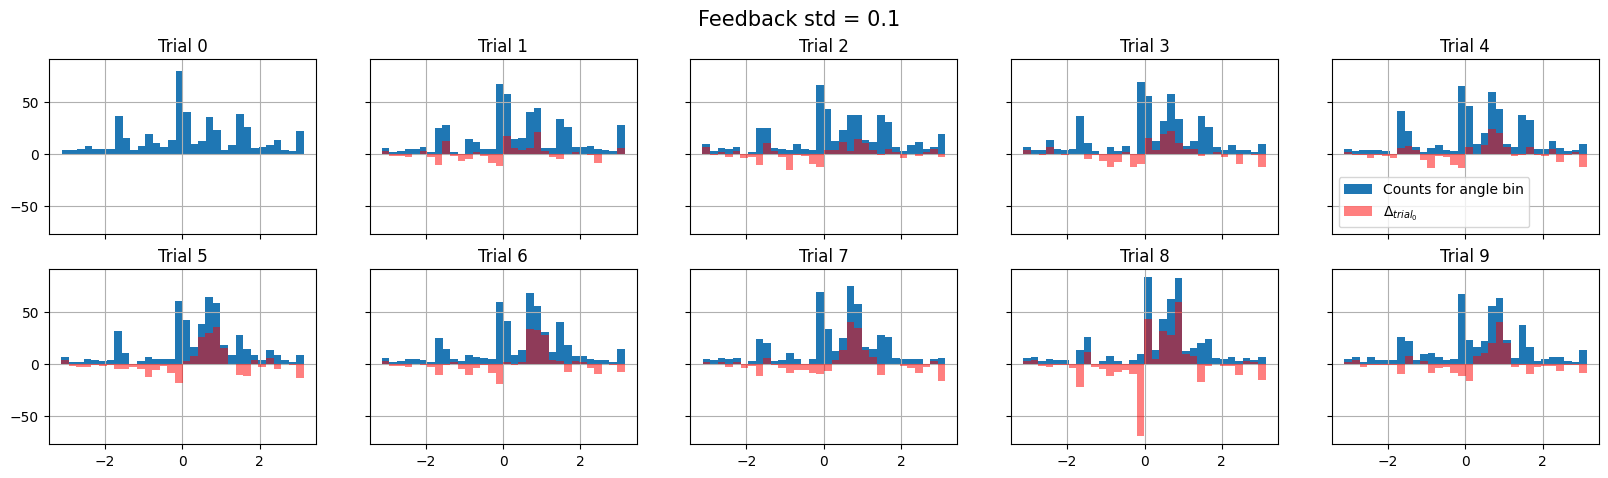

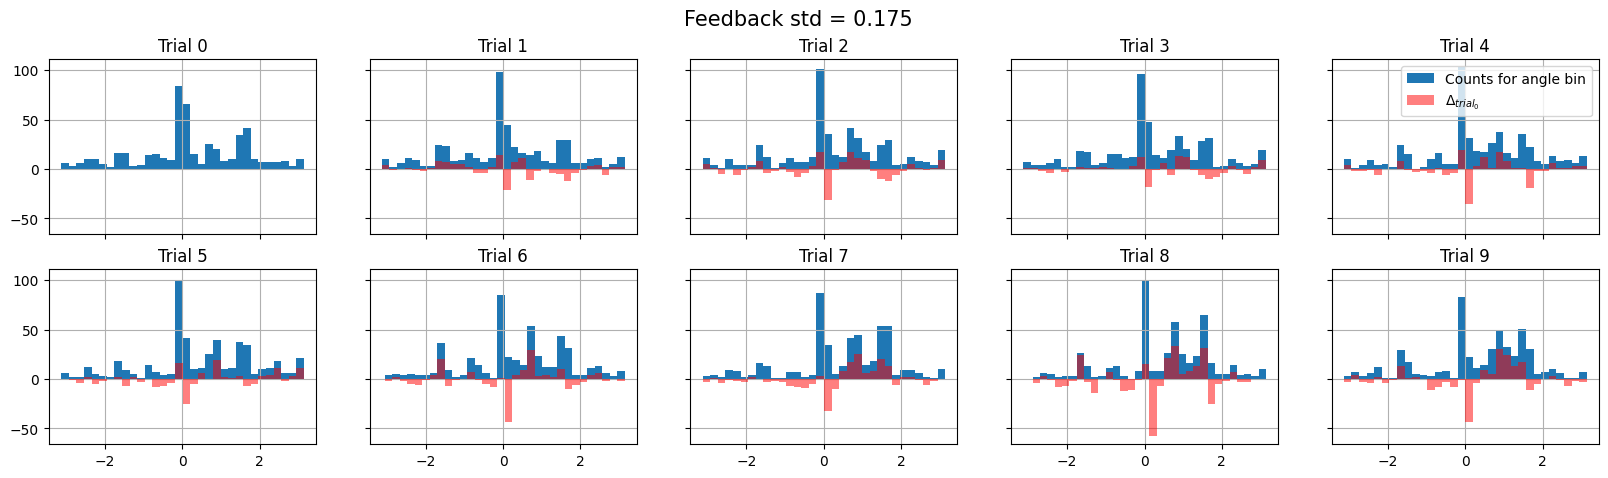

In [30]:
angles = np.stack(subjects_df["action_angles"])

Nsubj = angles.shape[0]
angles_flat = angles.reshape((Nsubj,-1))
Nactions = angles_flat.shape[-1]

fig,ax = plt.subplots(1,figsize=(6,6))
for subj in range(Nsubj):
    ax.scatter(np.arange(Nactions),angles_flat[subj],alpha=0.1,s=2)
    
# angles_flat = angles.reshape((Nsubj,-1))
gridx,gridy = 2,5
nbins=32
fig,axs = plt.subplots(gridx,gridy,figsize=(20,5),sharex=True,sharey=True)
for trial in range(Ntrials-1):
    ax = axs.flatten()[trial]
    ax.grid()
    ax.set_title("Trial {}".format(trial))
    # ax.hist(angles[:,trial,:].flatten(),bins=16)
    
    counts, edges, bars = ax.hist(angles[:,trial,:].flatten(), bins=nbins,histtype='barstacked',label="Counts for angle bin")
        
    if trial==0:
        initial_counts = counts
    else :
        delta_counts = counts-initial_counts
        ax.hist(edges[:-1],edges,weights=delta_counts,color="red",alpha=0.8,zorder=1000,label="$\Delta_{trial_0}$")
axs[0,-1].legend()



# Group by 'key' column
grouped_df = subjects_df.groupby('feedback_noise_std')              
Ncategories = len(grouped_df)

group_values = {}
for i,(key, group) in enumerate(grouped_df):
    action_angles_group = np.stack(group["action_angles"])
    
    fig,axs = plt.subplots(gridx,gridy,figsize=(20,5),sharex=True,sharey=True)
    fig.suptitle("Feedback std = {}".format(key),fontsize=15)
    
    for trial in range(Ntrials-1):
        ax = axs.flatten()[trial]
        ax.grid()
        ax.set_title("Trial {}".format(trial))
        # ax.hist(angles[:,trial,:].flatten(),bins=16)
        
        counts, edges, bars = ax.hist(action_angles_group[:,trial,:].flatten(),alpha=1.0, bins=nbins,histtype='barstacked',label="Counts for angle bin")
            
        if trial==0:
            initial_counts = counts
        else :
            delta_counts = counts-initial_counts
            ax.hist(edges[:-1],edges,weights=delta_counts,color="red",alpha=0.5,zorder=1000,label="$\Delta_{trial_0}$")

            delta_counts_prev = counts-last_counts
            # ax.hist(edges[:-1],edges,weights=delta_counts_prev,color="green",alpha=0.5,zorder=1000,label="$\Delta_{previous trial}$")
        
        last_counts = counts
    axs[0,-1].legend()

In [209]:
# This is still a bit hard to read, let's plot an alternative figure ! 
# Idea : polar histogram showing counts of actions performed by the subjects, with 
# each action given a specific color : 
# array of angles, between -pi and pi
angles = np.stack(subjects_df["action_angles"])
print(angles.shape)  # Nsubjects x Ntrials x Nactions

N_bin_categories = 32 # A multiple of 4 (or 8 !)

# The middle of the cardinal points should be the center of their respective bins
half_a_bin = (2*np.pi/(N_bin_categories))*0.5
bins = np.linspace(-np.pi + half_a_bin,np.pi - half_a_bin,N_bin_categories) 

digitized_angles = np.zeros_like(angles)
for subject in range(angles.shape[0]):
    for trial in range(angles.shape[1]):
        digitized_angles[subject,trial,:] = np.digitize(angles[subject,trial,:],bins)   
digitized_angles[digitized_angles > N_bin_categories-1] = 0
digitized_angles = digitized_angles.astype(int)

angle_counts = np.zeros((Nsubj,Ntrials,N_bin_categories))
for subject in range(angles.shape[0]):
    for trial in range(angles.shape[1]):
        angle_counts[subject,trial,:] = np.bincount(digitized_angles[subject,trial,:],minlength=N_bin_categories)


# Let's transform it into a pandas dataframe with 4 coordinates ! 
def using_multiindex(_array, columns):
    shape = _array.shape
    index = pd.MultiIndex.from_product([range(s)for s in shape], names=columns)
    df = pd.DataFrame({'Value': _array.flatten()}, index=index).reset_index()
    return df
df_digit_angles = using_multiindex(digitized_angles, ["Subject","Trial","Timestep"])
df_anglecounts = using_multiindex(angle_counts, ["Subject","Trial","Angle"])



# Plot the angles for each specific subject !
def get_fig_for_subject(subj_id,size=800):
    subject_anglecounts = df_anglecounts.loc[df_anglecounts["Subject"]==subj_id][["Trial", "Angle", "Value"]]
    subject_anglecounts["Angle_degrees"] = (subject_anglecounts["Angle"]/(N_bin_categories))*360 - 180
    fig = px.bar_polar(subject_anglecounts, r="Value", theta="Angle_degrees",
                    color="Trial", template="none",
                    labels={"Trial": "Trial when angle was input"},
                    hover_data={"Trial":True, "Value":True ,"Angle_degrees":True}
                    )

    fig.update_layout(width=size, height=size)

    PERCENT_MIDDLE = 0.30
    # maximum value for the array considered :
    max_angle_count = subject_anglecounts.groupby(['Angle'])["Value"].sum().max()
    min_val = -(PERCENT_MIDDLE/(1-PERCENT_MIDDLE))*max_angle_count

    # Adjust the layout to rotate the plot
    fig.update_layout(
        showlegend=False,
        polar=dict(
            angularaxis=dict(
                rotation=0, 
                thetaunit = "radians",
                direction = "counterclockwise"
            ),
            radialaxis = dict(
                range=[min_val,max_angle_count]
            )
        )
    )
    fig.update(layout_coloraxis_showscale=False)
    return fig

# Plot the angles for each specific subject !
def get_fig_for_all_subjects(size=800,showlegend=True):
    total_anglecounts = df_anglecounts.groupby(["Trial","Angle"])["Value"].sum()
    # total_anglecounts["Total"] = total_anglecounts["Value"].sum()
    total_anglecounts_df = total_anglecounts.reset_index()
    
    total_anglecounts_df["Angle_degrees"] = (total_anglecounts_df["Angle"]/(N_bin_categories))*360 - 180
    fig = px.bar_polar(total_anglecounts_df, r="Value", theta="Angle_degrees",
                    color="Trial", template="none",
                    labels={"Trial": "Trial when angle was input"},
                    hover_data={"Trial":True, "Value":True ,"Angle_degrees":True}
                    )

    fig.update_layout(width=size, height=size)

    PERCENT_MIDDLE = 0.30
    # maximum value for the array considered :
    max_angle_count = total_anglecounts_df.groupby(['Angle'])["Value"].sum().max()
    min_val = -(PERCENT_MIDDLE/(1-PERCENT_MIDDLE))*max_angle_count

    # Adjust the layout to rotate the plot
    fig.update_layout(
        showlegend=False,
        polar=dict(
            angularaxis=dict(
                rotation=0, 
                thetaunit = "radians",
                direction = "counterclockwise"
            ),
            radialaxis = dict(
                range=[min_val,max_angle_count]
            )
        )
    )
    fig.update(layout_coloraxis_showscale=showlegend)

    return fig

my_figure = get_fig_for_subject(0,600)
my_figure.show()

my_figure = get_fig_for_subject(1,600)
my_figure.show()


all_subjects_figure = get_fig_for_all_subjects()
all_subjects_figure.show()

(145, 11, 10)


## 3. Basic modelling : correlation between variables, statistical tests ...

C:\Users\annic\AppData\Local\Temp\ipykernel_17580\4034293437.py:21: UserWarning:


The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.

C:\Users\annic\AppData\Local\Temp\ipykernel_17580\4034293437.py:23: UserWarning:


The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.



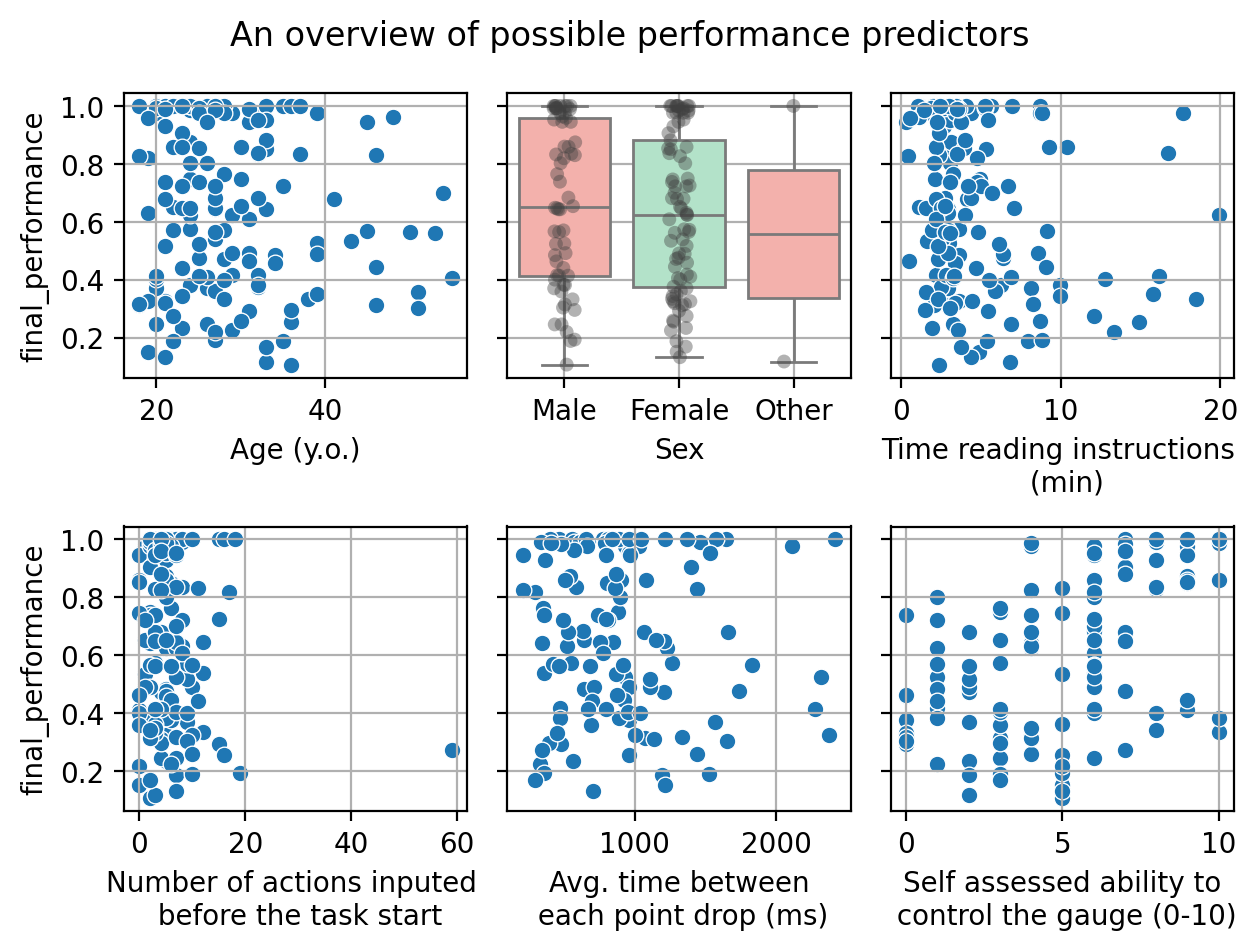

In [310]:
# Plot Age (regression), sex (histogram), time spent reading instructions (regression), number of points drawn (histogram) and average time before action (regression) vs performances of the subjects :

# First, let's get the values of interest for our subjects : 
# 1. The average (true) feedback level (over the whole training)
# 2. The average (true) feedback level (during the last K trials)

# Get subject personnal data !
fig,axes = plt.subplots(2,3,sharey=True,dpi=200)
fig.suptitle("An overview of possible performance predictors")

# 1. Ages !
ax1 = axes[0,0]
sns.scatterplot(ax=ax1, data=subjects_df,
                x="Age", y="final_performance")
ax1.set_xlabel("Age (y.o.)")
ax1.grid()

# 2. Sexes !
sexes = [subj_task_results[0]["Sex"] for subj_task_results in TASK_RESULTS]
ax2 = axes[0,1]
sns.boxplot(ax = ax2, x="Sex", y="final_performance", hue="Sex",
                data=subjects_df,palette=["#FFA7A0", "#ABEAC9"],dodge=False)
sns.stripplot(ax=ax2 , x="Sex", y="final_performance", 
                hue="Sex",data=subjects_df,palette=["#404040","#404040"], 
                alpha=0.4, dodge=False)
ax2.grid()

# 3. Time spent reading the instructions 
ax3 = axes[0,2]

instr_all_subj = [subj_task_results[1]["instructions"] for subj_task_results in TASK_RESULTS]
t_starts = [[evt["t"] for evt in instr if evt["val"]=="start_instructions" ] for instr in instr_all_subj]
t_ends = [[evt["t"] for evt in instr if evt["val"]=="end_instructions" ] for instr in instr_all_subj]
delta_ts = [(end[0]-start[0])/(60*1000.0) for (end,start) in zip(t_ends,t_starts)]
subjects_df["TimeReadingInstructions"] = delta_ts
sns.scatterplot(ax=ax3, data=subjects_df,
                x="TimeReadingInstructions", y="final_performance")
ax3.grid()
ax3.set_xlabel("Time reading instructions \n (min)")

# 4. Numver of points dropped on the trial action screen
ax4 = axes[1,0]
subjects_df["N_actions_tested"] = [len(try_points) for try_points in subjects_df["canvas_explore_points"].values]
sns.scatterplot(ax=ax4, data=subjects_df,
                x="N_actions_tested", y="final_performance")
ax4.grid()
ax4.set_xlabel("Number of actions inputed \n before the task start")

# 5. Average time between the two points !
ax5 = axes[1,1]
subjects_df["time_between_points"] = np.mean(np.stack(subjects_df["action_time_between_points"]),axis=(-1,-2))
sns.scatterplot(ax=ax5, data=subjects_df,
                x="time_between_points", y="final_performance")
ax5.set_xlabel("Avg. time between\n each point drop (ms)")
ax5.grid()

# 6. Self assessment at the end of the task
ax6 = axes[1,2]
sns.scatterplot(ax=ax6, data=subjects_df,
                x="mandatory_q1", y="final_performance")
ax6.set_xlabel("Self assessed ability to\n control the gauge (0-10)")
ax6.grid()

fig.tight_layout()

Let's now explore the effect of the feedback noise on our performance metric ! 

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning:

invalid value encount

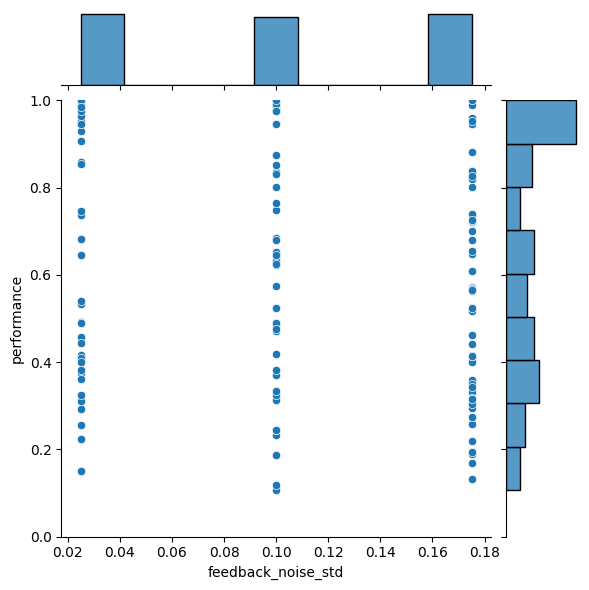

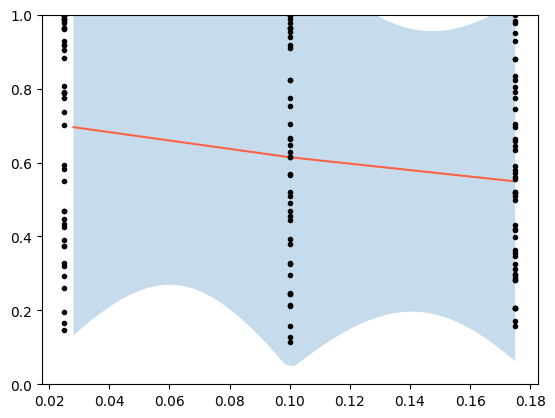

In [297]:
# Raw data :
g = sns.jointplot(data=subjects_df,x="feedback_noise_std", y="performance",ylim = (0,1))
x_limits = g.ax_joint.get_xlim()
y_limits = g.ax_joint.get_ylim()

# Get general tendencies + rough fitting :
# LOESS + bootstrapping (see https://james-brennan.github.io/posts/lowess_conf/)

from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
x,y = subjects_df["feedback_noise_std"],subjects_df["final_performance"]
sm_x, sm_y = sm_lowess(y, x,  frac=1./5., 
                           it=5, return_sorted = True).T

# # One lowess:
# fig,ax = plt.subplots(1)
# ax.plot(sm_x, sm_y, color='tomato')
# ax.plot(x, y, 'k.')

import scipy.interpolate

def smooth(x, y, xgrid,percent=50):
    samples = np.random.choice(len(x), int(len(x)*percent/100.0), replace=False)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s,x_s, frac=1./5., it=5,
                     return_sorted = False)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

xgrid = np.linspace(x.min(),x.max())
K = 100
smooths = np.stack([smooth(x, y, xgrid) for k in range(K)]).T

# # K bootstrapped lowess
# fig,ax = plt.subplots(1)
# ax.plot(xgrid, smooths, color='tomato', alpha=0.25)
# ax.plot(x, y, 'k.')
# fig.show()

# Plot with 95% confidence interval (assuming gaussian dist) !
mean = np.nanmean(smooths, axis=1)
stderr = scipy.stats.sem(smooths, axis=1)
stderr = np.nanstd(smooths, axis=1, ddof=0)
# plot it
fig,ax = plt.subplots(1)
ax.fill_between(xgrid, mean-1.96*stderr,
                     mean+1.96*stderr, alpha=0.25)
ax.plot(xgrid, mean, color='tomato')
ax.plot(x, y, 'k.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
fig.show()

The results here are quite surpsing, it seems that the intensity of the feedback variations had no real effect on the ability of the subjects to control the gauge, suggesting that other factors (relating to subject individual representations) may have played a crucial role in learning to control the gauge. 

It seems that in this task, the performance of our subjects follow a mixture of (half)gaussian model with two clusters of means ($\sim1.0$ (learners) and $\sim0.4$ (non-learners)). This follows a very non-linear "either you get it or you don't" type of reasoning, stemming from the pattern recognition of the subjects. 

However, let's also note the unusual design of the feedback noise : it consisted in a fixed frequency (1HZ) oscillating around an unbiasied value. The maximum difference value was given by the intensity parameter (where 0.0 is no oscillation at all and 1.0 is the oscillation may cover the whole gauge). This value is not really enough to correctly qualify the effect of noise : we have to look at individual trials feedback values. Thankfully, we have recorded them ! 

## Real time feedback

Let's extract the real time feedback curves and get the evolution of the feedback in the time that followed each action (don't forget to account for prompts).

## Transfer

Last trial : the 11th (and last) trial was done without a gauge. Let's compare its performance and the previous performances ! 

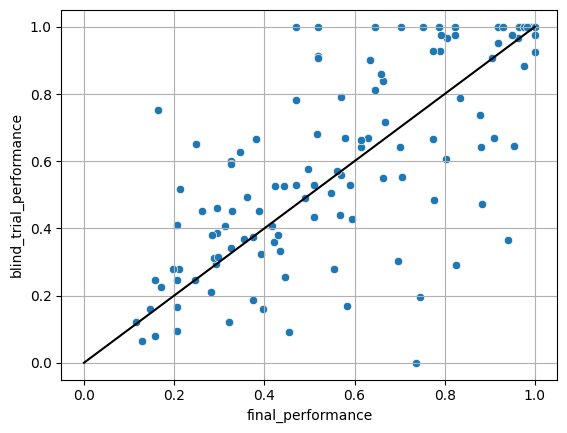

In [317]:
fig,ax = plt.subplots(1)
ax.grid()
sns.scatterplot(ax=ax,data = subjects_df,x="final_performance",y="blind_trial_performance")

linspace_perf_vals = np.linspace(0,1,1000)
ax.plot(linspace_perf_vals,linspace_perf_vals,color="black")


There is clearly a positive correlation, seemingly well fit by a MoG model (K=2 clusters).

## More analysis ?

A more refined (subject-centered) modeling approach where the noise of the feedback is not the only predictor


Possible next steps : 
- Linear models (ANCOVA) of : performance ~ Age + Sex + TimeReadingInstr + NumberOfTestedActions ?
- More predictive models, to compare to usual Neurofeedback predictors :D
- More interesting variables : 
    - Time between feedback gauge update end & first action point
    - Ability to correctly predict the effect of ones' action
    - Employment / Student status + Number of Prolific tasks conducted previously
- Lexical analysis of subject return over experience ?

## ANNEX : SUBJECT ANSWERS ON STRATEGY AND TASK DESIGN

In [405]:
# Warning, the questions asked may vary based on the task ID !
print("According to you, what was the best strategy in order to control the gauge level ? In retrospect, what other strategy should you have attempted ? (Try to answer as precisely as possible.)")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["mandatory_q2"])
    # print("-> " + subject_dict["Nationality"])
print()
print("Did you notice any technical issues (buttons not working, graphical bugs, etc.) ? If yes, how did they appear ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q1"])
print() 
print("The instructions were meant to help you understand the task before it started. How clear did you find them ? What would you change to make them clearer ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q2"])
print() 
print("Do you think there was a logic behind how the gauge responded ? How hard / frustrating did you find the task ? Other remarks ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q3"])
print() 

According to you, what was the best strategy in order to control the gauge level ? In retrospect, what other strategy should you have attempted ? (Try to answer as precisely as possible.)
__________________________________________________________________________
-> After the first couple of trials, I realised the corners were the most likely to yield an increase in the gauge level.
-> My strategy was to test out with the first few actions and then don't risk at all.
-> Trying to put the dots close to each other
-> I felt like I had no control - I did not work out how to control it
-> My strategy was to try to find something that increased the level and then continue to do a similar thing for the next steps. I tried seeing if different quadrants had obvious affects and the same as the direction of the line being created between the 2 points, but there didn't seem to be an obvious correlation for each trial. 
-> I had no idea what kind of mechanism was it so I just clicked randomly by "t